In [1]:
from SimPEG import Mesh, Utils, Maps, PF, Regularization, Optimization, Directives, DataMisfit, InvProblem, Inversion
from SimPEG.Utils import mkvc
from discretize.utils import meshutils
from GeoToolkit.Mag import Simulator
from scipy.spatial import cKDTree
from dask.distributed import Client
import numpy as np
import scipy as sp
import os
from skimage.morphology import skeletonize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# client = Client(n_workers=2)

In [3]:
from SimPEG.Utils.PlotUtils import plotModelSections, plotProfile
from SimPEG.Utils import sdiag, speye, kron3


def Rz(theta):
    """Rotation matrix about z axis"""
#     theta = np.deg2rad(theta)
    Rz = np.vstack(
        (np.r_[np.cos((theta)), -np.sin((theta)), 0],
         np.r_[np.sin((theta)), np.cos((theta)), 0],
         np.r_[0, 0, 1])
    )
    
    return Rz
                          
def Ry(theta):
    """Rotation matrix about y axis"""
#     theta = np.deg2rad(theta)
    Ry = np.vstack(
        (np.r_[np.cos((theta)), 0, np.sin((theta))],
         np.r_[0, 1, 0],
         np.r_[-np.sin((theta)), 0, np.cos((theta))])
    )

    return Ry

def Rx(theta):
    """Rotation matrix about y axis"""
#     theta = np.deg2rad(theta)
    Rx = np.vstack(
        (np.r_[1, 0, 0],
         np.r_[0, np.cos((theta)), -np.sin((theta))],
         np.r_[0, np.sin((theta)), np.cos((theta))])
    )

    return Rx

def plotMarkers(xyz, azm, dip, ms = 1, color = np.r_[1,1,1,1]):
    """
        Function to plot a stratigraphic marker at location xyz
    """
    def Rz(theta):
        """Rotation matrix about z axis"""
        theta = -np.deg2rad(theta+90)
        Rz = np.vstack((np.r_[np.cos((theta)),
                              -np.sin((theta))],
                       np.r_[np.sin((theta)),
                             np.cos((theta))]))
        return Rz

    xtick = np.r_[ms,0]
    ytick = np.r_[0,ms]
    
    for ii in range(xyz.shape[0]):
        
        xx = np.dot(Rz(azm[ii]),xtick) 
        yy = np.dot(Rz(azm[ii]),ytick)
        
        plt.plot(np.r_[xyz[ii,0]- xx[0],xyz[ii,0]+xx[0]], np.r_[xyz[ii,1]-xx[1],xyz[ii,1]+xx[1]], c=color, linewidth=3, zorder=10)
        plt.plot(np.r_[xyz[ii,0], xyz[ii,0]+ yy[0]], np.r_[xyz[ii,1], xyz[ii,1]+yy[1]], c=color, linewidth=3, zorder=10)
        plt.text(xyz[ii,0]-yy[0],xyz[ii,1]-yy[1],str(int(dip[ii]))+'$^\circ$', fontsize=16, ha = 'center', va='center', color=color, zorder=10)
        


In [4]:
def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k',
                      title=None, axs=None, actv=None, contours=None, fill=True,
                      orientation='vertical', cmap='pink_r'):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m[np.isnan(m)!=True].min()

    if vmax is None:
        vmax = m[np.isnan(m)!=True].max()

    if len(m) == 3*nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        m_lpz = m[2*nC:]

        if actv is not None:
            m_lpx[actv!=True] = np.nan
            m_lpy[actv!=True] = np.nan
            m_lpz[actv!=True] = np.nan

        amp = np.sqrt(m_lpx**2. + m_lpy**2. + m_lpz**2.)

        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        amp = amp.reshape(mesh.vnC, order='F')
    else:

        if actv is not None:
            m[actv!=True] = np.nan

        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if normal == 'x':
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif normal == 'y':
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    elif normal == 'z':

        if actv is not None:
            actIndFull = np.zeros(mesh.nC, dtype=bool)
            actIndFull[actv] = True
        else:
            actIndFull = np.ones(mesh.nC, dtype=bool)

        actIndFull = actIndFull.reshape(mesh.vnC, order='F')

        model = np.zeros((mesh.nCx, mesh.nCy))
        mx = np.zeros((mesh.nCx, mesh.nCy))
        my = np.zeros((mesh.nCx, mesh.nCy))
        for ii in range(mesh.nCx):
            for jj in range(mesh.nCy):

                zcol = actIndFull[ii, jj, :]
                model[ii, jj] = amp[ii, jj, np.where(zcol)[0][-ind]]

                if len(m) == 3*nC:
                    mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
                    my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

        xx = xx[:, :, ind].T
        yy = yy[:, :, ind].T
        model = model.T
        
        amp = np.kron(np.ones(mesh.nCz), mkvc(model.T))
        if len(m) == 3*nC:
            mx = mx[::subFact, ::subFact].T
            my = my[::subFact, ::subFact].T

    im2, cbar = [], []
    if fill:
#         im2 = axs.contourf(xx, yy, model,
#                            30, vmin=vmin, vmax=vmax,
#                            cmap=cmap)

        im2 = mesh.plotSlice(mkvc(amp), ind=ind, normal=normal.upper(), ax=axs, clim=[vmin, vmax],
                             pcolorOpts={'clim':[vmin, vmax] ,'cmap':'pink_r'})

        cbar = plt.colorbar(im2[0], orientation=orientation, ax=axs,
                 ticks=np.linspace(vmin, vmax, 4),
                 format="${%.3f}$", shrink=0.5)

    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if len(m) == 3*nC:

        axs.quiver(mkvc(xx[::subFact, ::subFact]),
                   mkvc(yy[::subFact, ::subFact]),
                   mkvc(mx),
                   mkvc(my),
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30)

    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    return axs, im2, cbar

In [5]:
work_dir = '.\\'
driver = PF.GravityDriver.GravityDriver_Inv(input_file=work_dir + 'SimPEG_GRAV.inp')
mesh3D = driver.mesh

tree3D = cKDTree(mesh3D.gridCC)

# mesh = Mesh.TensorMesh.readUBC(work_dir+'Mesh_20m.msh')
model, ndv = Mesh.TensorMesh.readModelUBC(mesh3D,work_dir+'TopoFold_20mCover.den'), -100
survey = driver.survey
survey.rxLoc[:,2] += 10

topo = np.genfromtxt(work_dir + driver.topofile, skip_header=1)

# topo = topo[(topo[:,0]> 421750) * (topo[:,0]< 424000) * (topo[:,1]< 546500) * (topo[:,1] > 545000), :]
# Generate data
actv3D = driver.activeModel == 1
model[model == ndv] = 0
# actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# nC = int(np.sum(actv))

mk = np.loadtxt(work_dir + 'Structural_Markers.dat')
pts, dip, azm = mk[:,:3], mk[:,3], mk[:,4]

foldAxis = np.dot(Rx(np.deg2rad(12.5)),np.dot(Ry(np.deg2rad(-15)),np.r_[0,1,0]))
x0,y0,z0 = 423029.0, 545779.0, 1450
foldVec = np.c_[x0, y0, z0] + foldAxis*500
foldVec = np.r_[foldVec, np.c_[x0, y0, z0] - foldAxis*500]


In [6]:
# Create an octree mesh and interpolate model onto
# mesh = meshutils.mesh_builder_xyz(topo, [20,20,20], depth_core=500, mesh_type='TREE', base_mesh=mesh3D)

# mesh = meshutils.refine_tree_xyz(mesh, survey.rxLoc, octree_levels=[12], octree_levels_padding=[3], method='surface', finalize=False)
# mesh = meshutils.refine_tree_xyz(mesh, topo, octree_levels=[0,10], method='surface', finalize=True)
mesh = Mesh.TreeMesh.readUBC("TopoFold_varRotation\\GRAV_Tile_Theta0.msh")


actv = Utils.modelutils.surface2ind_topo(mesh, topo, gridLoc='CC')


r, ind = tree3D.query(mesh.gridCC)

modelTree = model[ind]
modelTree[actv==False] = np.nan
nC = int(actv.sum())

In [35]:
# Find top layer
indTop = Utils.modelutils.activeTopoLayer(mesh, topo, index=4)

# Propagate to top
treeTop = cKDTree(mesh.gridCC[indTop,:2])

r, indModel = treeTop.query(mesh.gridCC[:,:2])

modelTop = modelTree[indTop][indModel]


In [36]:
def plotVectorsOctree(mesh, theta, phi, coord, 
                      axs=None, scale=1, 
                      lims=[[-100, 100], [-100, 100]], 
                      color='w', resolution=10, normal='Z', 
                      actvMap=None, zorder=1):
    
    nC = theta.shape[0]
#     m = m.reshape((nC, 3), order='F')
    
    normalInd = {'X': 0, 'Y': 1, 'Z': 2}[normal]
    antiNormalInd = {'X': [1, 2], 'Y': [0, 2], 'Z': [0, 1]}[normal]

#     xLim = (mesh.gridCC[:, antiNormalInd[0]].min(), mesh.gridCC[:, antiNormalInd[0]].max())
#     yLim = (mesh.gridCC[:, antiNormalInd[1]].min(), mesh.gridCC[:, antiNormalInd[1]].max())
    xLim = [lims[0][0], lims[0][1]]
    yLim = [lims[1][0], lims[1][1]]

    X,Y = np.meshgrid(np.arange(xLim[0], xLim[1], resolution), np.arange(yLim[0], yLim[1], resolution))
    Z = np.ones_like(X) * coord
    
    grid = np.zeros((np.ravel(X).shape[0], 3))

    grid[:, normalInd] = np.ravel(Z)
    grid[:, antiNormalInd] = np.c_[np.ravel(X), np.ravel(Y)]
    ind = np.unique(mesh._get_containing_cell_indexes(grid))
    
    amp = np.ones_like(theta)
    # Interpolate values to mesh.gridCC if not 'CC'
    if actvMap is not None:
#         mx = (actvMap*m[:, 0])
#         my = (actvMap*m[:, 1])
#         mz = (actvMap*m[:, 2])

#         m = np.c_[mx, my, mz]
        amp = actvMap * amp
        theta = actvMap * theta
        phi = actvMap * phi
    
        
      
    if axs is None:
        axs = plt.subplot()
        
#     print(grid)

    vec = Utils.matutils.atp2xyz(np.c_[amp, theta, phi]).reshape((mesh.nC,3), order='F')
    
    print(antiNormalInd[0], antiNormalInd[1])
    axs.quiver(mesh.gridCC[ind, antiNormalInd[0]],
               mesh.gridCC[ind, antiNormalInd[1]],
               vec[ind, antiNormalInd[0]],
               vec[ind, antiNormalInd[1]],
               pivot='mid',
               scale_units="inches", scale=scale, linewidths=(1,),
               edgecolors=color,
               headaxislength=0.1, headwidth=10, headlength=30, zorder=zorder)
    
    return axs


def plot3Panels(mplot, fileName ,subFact=None, plotMarker=True, scale=None, vmin=None, vmax=None, color=np.r_[1,1,1,1]):

    fig = plt.figure(figsize=(14,8))

    indz = 2
    indy = int(mesh3D.nCy/2)-6
    indx = int(mesh3D.nCx/2)+12

    xlim = [422050, 423500]
    ylim = [545150, 546450]
    zlim = [1000, 1600]

    x = [422250, 422750, 423250]
    y = [545250, 545750, 546250]
    z = [1300, 1450, 1600]
    
    if vmin is None:
        vmin = mplot.min()
        
    if vmax is None:
        vmax = mplot.max()
#     axs = plt.subplot(2,1,2)

    axs = plt.subplot(1,2,1)
    modelTop = mplot[indTop][indModel]
    mesh.plotSlice(modelTop, normal = 'Z',ind=int(np.searchsorted(mesh.vectorCCz, 1480)), pcolorOpts={"cmap":'cubehelix_r', "clim":[vmin, vmax], "vmax":vmax, "vmin":vmin}, grid=True, ax=axs)
#     axs, im, cbar = plotModelSections(mesh, mplot, actv = actv, normal='z',subFact=subFact, scale=scale, ind=indz, cmap='pink_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
    # plotTopo(topo, axs=axs, fill=False)
    if plotMarker:
        plotMarkers(pts, azm, dip, ms = 50, color='r')
    # plt.scatter(survey.srcField.rxList[0].locs[:,0],survey.srcField.rxList[0].locs[:,1], 5, color='k')

    plt.plot(xlim, [mesh3D.vectorCCy[int(indy)], mesh3D.vectorCCy[int(indy)]], c='k', linestyle='--')
    plt.text(xlim[0],mesh3D.vectorCCy[int(indy)],'A', fontsize = 16)
    plt.text(xlim[1],mesh3D.vectorCCy[int(indy)],"A'", fontsize = 16, ha = 'right')
    plt.plot([mesh3D.vectorCCx[int(indx)], mesh3D.vectorCCx[int(indx)]], ylim, c='k', linestyle='--')
    plt.text(mesh3D.vectorCCx[int(indx)], ylim[0],'B', fontsize = 16)
    plt.text(mesh3D.vectorCCx[int(indx)], ylim[1],"B'", fontsize = 16, va = 'top')
    
    # Plot fold axis
    if plotMarker:
        plt.plot(foldVec[:,0], foldVec[:,1], ylim, c='r', linestyle='-.')
    
    axs.set_xticks(list(map(int, x)))
    axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
    axs.set_xlabel('Easting (m)', size=12)
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.set_yticks(list(map(int, y)))
    axs.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
    axs.set_ylabel('Northing (m)', size=12)
    pos = axs.get_position()
    axs.set_aspect('equal')
    axs.set_position([pos.x0-0.05, pos.y0-0.01,  pos.width*1.15, pos.height*1.15])
    axs.set_title('Plan View', fontsize=14)

    # EW PROFILE #
    axs = plt.subplot(2,2,2)
#     axs, im, cbar = plotModelSections(mesh, mplot, normal='y', actv = actv,subFact=subFact, scale=scale, ind=indy, cmap='pink_r', axs=axs,xlim=xlim, ylim=zlim, vmin=vmin, vmax=vmax)
    
    mesh.plotSlice(mplot, normal='Y', 
                   ind=int(np.searchsorted(mesh.vectorCCy, mesh3D.vectorCCy[indy])), 
                   grid=True, pcolorOpts={"cmap":'cubehelix_r', "clim":[vmin, vmax], "vmax":vmax, "vmin":vmin}, ax=axs)
    plotModelSections(mesh3D, model,normal='y', actv = actv3D, ind=indy,subFact=subFact, scale=scale, cmap='pink_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

    # plotModelSections(mesh, mkvc(mout), normal='y', ind=indy,subFact=4, scale=7., cmap='pink_r', axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

    topodrapped = topo.copy()
    topodrapped[:,-1] -= np.sum(mesh.hz[-indz-1:])
    
    plotProfile(topo, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                             50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                             plotStr='k')
    
    plot(np.r_[mesh3D.vectorCCx[indx], mesh3D.vectorCCx[indx]], zlim, 'k--')
    text(mesh3D.vectorCCx[indx], zlim[1],"B-B'", va='bottom', ha='center', size=12)
    plotProfile(topodrapped, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                             50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                             plotStr='k--')

    plotProfile(survey.srcField.rxList[0].locs, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                             18, ax=axs, fig=fig, coordinate_system = 'xProfile',
                             plotStr='k.')
    # Plot fold axis
    Rx = np.vstack(
        (np.r_[np.cos(np.deg2rad(15)), -np.sin(np.deg2rad(15))],
         np.r_[np.sin(np.deg2rad(15)), np.cos(np.deg2rad(15))])
    )

    line = np.dot(Rx, np.c_[foldVec[:,0]-x0,foldVec[:,2]-z0].T )

    if plotMarker:
        plt.plot(line[0,:]+x0, line[1,:]+z0, c='r', linestyle='-.')
    
#     cbar.remove()
    axs.set_xlabel('Easting (m)', size=12)
    axs.set_xticks(list(map(int, x)))
    axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

    axs.set_ylabel('Elevation (m)', size=12)
    axs.set_yticks(list(map(int, z)))
    axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
    pos = axs.get_position()
    axs.set_position([pos.x0, pos.y0,  pos.width*1.25, pos.height*1.25])
    axs.set_title('A',loc='left', fontsize=14)
    axs.set_title("A'",loc='right', fontsize=14)
    axs.set_title("",loc='center', fontsize=14)
    

    # NS PROFILE #
    axs = plt.subplot(2,2,4)

#     axs, im, cbar = plotModelSections(mesh, mplot, normal='x', actv = actv, ind=indx, cmap='pink_r',subFact=subFact, scale=scale, axs=axs,xlim=ylim, ylim=zlim, vmin=vmin, vmax=vmax)
    im = mesh.plotSlice(mplot, 
                   ind=int(np.searchsorted(mesh.vectorCCx, mesh3D.vectorCCx[indx])),
                   normal='X', pcolorOpts={"cmap":'cubehelix_r', "clim":[vmin, vmax], "vmax":vmax, "vmin":vmin}, grid=True, ax=axs)
    plotModelSections(mesh3D, model,normal='x',actv = actv3D, ind=indx,subFact=subFact, scale=scale, contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)
    # plotModelSections(mesh, mkvc(rz1), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', axs=axs, vmin=0. ,vmax=0.1, fill=False)

    # plotModelSections(mesh, mkvc(mout), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

    plot(np.r_[mesh3D.vectorCCy[indy], mesh3D.vectorCCy[indy]], zlim, 'k--')
    text(mesh3D.vectorCCy[indy], zlim[1],"A-A'", va='bottom', ha='center', size=12)
    plotProfile(topo, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                             50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                             plotStr='k')
    
    plotProfile(topodrapped, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                             50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                             plotStr='k--')

    plotProfile(survey.srcField.rxList[0].locs, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                             18, ax=axs, fig=fig, coordinate_system = 'yProfile',
                             plotStr='k.')
    # Plot fold axis
    if plotMarker:
        plt.plot(foldVec[:,1], foldVec[:,2], ylim, c='r', linestyle='-.')

#     cbar.remove()
    axs.set_xlabel('Northing (m)', size=12)
    axs.set_xticks(list(map(int, y)))
    axs.set_xticklabels(map(str, map(int, y)),size=12, ha='center')

    axs.set_ylabel('Elevation (m)', size=12)
    axs.set_yticks(list(map(int, z)))
    axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
    pos = axs.get_position()
    axs.set_position([pos.x0, pos.y0+0.06,  pos.width*1.25, pos.height*1.25])
    axs.set_title('B',loc='left', fontsize=14)
    axs.set_title("B'",loc='right', fontsize=14)
    axs.set_title("",loc='center', fontsize=14)
    

    axbar = plt.axes([pos.x0-0.15, pos.y0-0.025,  pos.width*.75, pos.height*.75])
    cbar = plt.colorbar(im[0], orientation='horizontal',format='%.3f')
    cbar.set_ticks(np.linspace(-.0,0.1,4))
    cbar.set_label("g/cc", size=14)
#     axbar.text(pos.x0+0.5, pos.y0-.45,'g/cc', size=14)
    axbar.axis('off')
    plt.savefig(fileName, bbox_inches='tight')

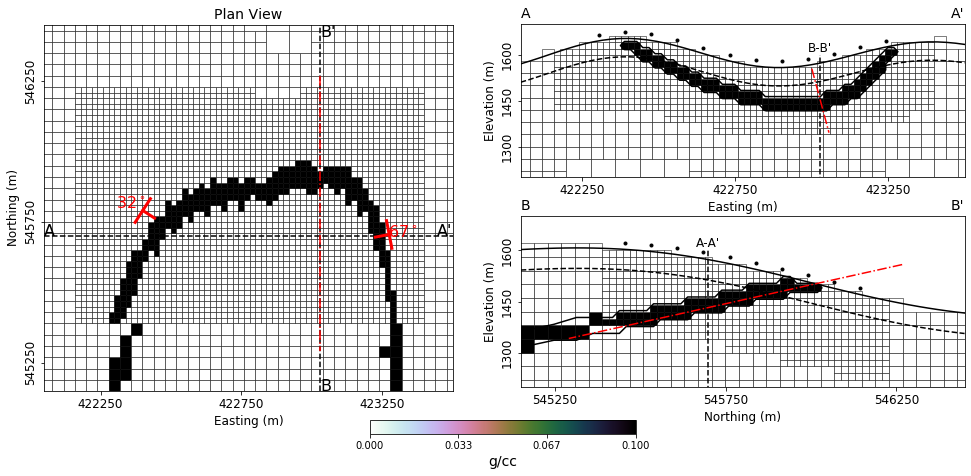

In [37]:
fileName = work_dir + 'Synthetic_Fold_Model.png'
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)
plot3Panels(modelTree,fileName, vmin = 0., vmax=0.1)

actvOut = Maps.InjectActiveCells(mesh, actv, -100)

Mesh.TreeMesh.writeUBC(mesh, 'MeshOctree.msh', models={'TrueOctree.den':actvOut*modelTree[actv]})

In [38]:
# Create a sub-survey and sub-sample randomly
nD = survey.srcField.rxList[0].locs.shape[0]
nDsub = int(nD*0.5)

print("nD ratio:" + str(nDsub) +'\\' + str(nD) )
indx = np.random.randint(0, high=nD, size=nDsub)
# Create a new downsampled survey
locXYZ = survey.srcField.rxList[0].locs[indx,:]

dobs = survey.dobs
std = survey.std

rxLoc = PF.BaseGrav.RxObs(locXYZ)
srcField = PF.BaseMag.SrcField([rxLoc], param=survey.srcField.param)
survey = PF.BaseMag.LinearSurvey(srcField)
survey.dobs = dobs[indx]
survey.std = std[indx]



nD ratio:1127\2255


In [39]:
# actIndFull = np.zeros(mesh.nC, dtype=bool)
# actIndFull[actv] = True
# ind=1
# actIndFull = actIndFull.reshape(mesh.vnC, order='F')

# newModel = model.reshape(mesh.vnC, order='F').copy()
# mx = np.zeros((mesh.nCx,mesh.nCy))
# my = np.zeros((mesh.nCx,mesh.nCy))
# for ii in range(mesh.nCx):
#     for jj in range(mesh.nCy):

#         zcol = actIndFull[ii, jj, :]
#         newModel[ii, jj, np.where(zcol)[0][-ind]] = 0

# #         if len(m) == 3*nC:
# #             mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
# #             my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

# Mesh.TensorMesh.writeModelUBC(mesh,work_dir+'TopoFold_20mCover.den', newModel)
# # xx = xx[:, :, ind].T
# # yy = yy[:, :, ind].T
# # model = model.T

In [40]:
import shutil
shutil.rmtree("./sensitivity.zarr")

idenMap = Maps.IdentityMap(nP=nC)
prob = PF.Gravity.GravityIntegral(mesh, rhoMap = idenMap, actInd=actv, parallelized='dask')

survey.unpair()
survey.pair(prob)

data = prob.fields(modelTree[actv])

survey.dobs = np.asarray(data)
survey.std = np.asarray(data)**0.*1e-3

# PF.Gravity.writeUBCobs(work_dir + 'Grid_25m_Randn.obs',survey,  data)

Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  1127 60716
RAM/tile:  4.379323648000001
Total RAM (x n_cpu):  35.034589184000005
Saving G to zarr: ./sensitivity.zarr
[########################################] | 100% Completed | 28.0s


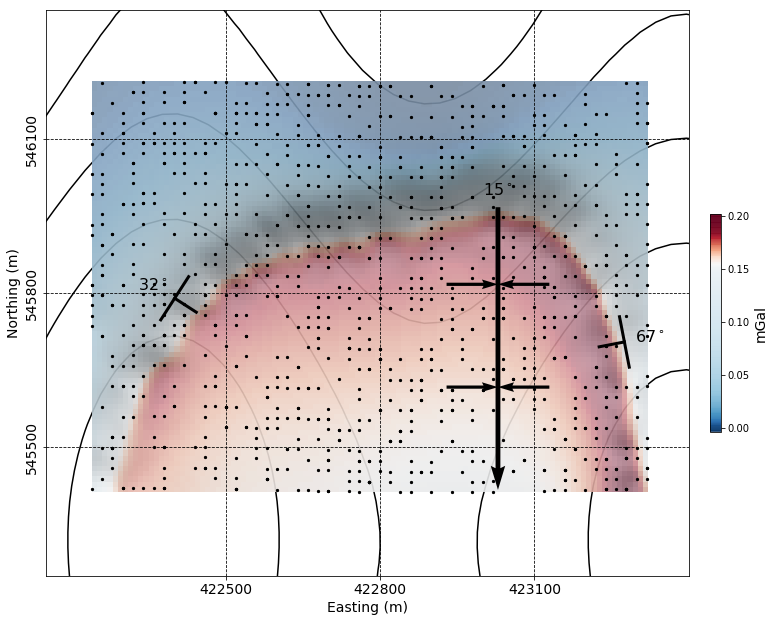

In [13]:
fileName = 'FoldData.png'

fig = plt.figure(figsize=(14,8))

xlim = [422150, 423400]
ylim = [545250, 546350]


x = [422500, 422800, 423100]
y = [545500, 545800, 546100]

xy = survey.srcField.rxList[0].locs[:,:2]
# gridObs, dMinCurv = Utils.modelutils.minCurvatureInterp(xy, survey.dobs, gridSize = 10)

# dMinCurv= dMinCurv.reshape(gridObs.vnC,order='F')
# X = gridObs.gridCC[:,0].reshape(gridObs.vnC, order='F')
# Y = gridObs.gridCC[:,1].reshape(gridObs.vnC, order='F')

axs = plt.subplot()

topoCC, topoGrid= Utils.modelutils.minCurvatureInterp(topo[::3,:2], topo[::3,2], gridSize = 30)

axs.contour(topoCC.gridCC[:,0].reshape(topoCC.vnC, order='F'),
            topoCC.gridCC[:,1].reshape(topoCC.vnC, order='F'),
            topoGrid.reshape(topoCC.vnC, order='F'), colors='k', zorder = -1)

# plotTopo(topo, axs=axs, fill=False)
X,Y,d, im, CS = Simulator.plotDataHillside(xy[:, 0], xy[:, 1], survey.dobs, resolution=10, 
                          axs=axs, cmap='RdBu_r', vmin=survey.dobs.min(), vmax=survey.dobs.max(),               
                          alpha=0.8, alphaHS=0.5, ve=500., azdeg=180, altdeg=30)

# Plot fold axis
plt.quiver(foldVec[0,0], foldVec[0,1]-300, 0, -550, angles='xy', scale_units='xy', scale=1.)
plt.quiver(foldVec[0,0]-100, foldVec[0,1]-450, 100, 0, angles='xy', scale_units='xy', scale=1., width=.005)
plt.quiver(foldVec[0,0]+100, foldVec[0,1]-450, -100, 0, angles='xy', scale_units='xy', scale=1., width=.005)
plt.quiver(foldVec[0,0]-100, foldVec[0,1]-650, 100, 0, angles='xy', scale_units='xy', scale=1., width=.005)
plt.quiver(foldVec[0,0]+100, foldVec[0,1]-650, -100, 0, angles='xy', scale_units='xy', scale=1., width=.005)
plt.text(foldVec[0,0], foldVec[0,1]-275,'$15^\circ$', size=16, ha='center')

# Add points at the survey locations
plt.scatter(xy[:,0], xy[:,1], s=5, c='k')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=14, ha='center')
axs.set_xlabel('Easting (m)', size=14)

axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=14, va='center', rotation=90)
axs.set_ylabel('Northing (m)', size=14)
axs.grid(True, color='k', linestyle='--')
axs.set_aspect('equal')

plotMarkers(pts, azm, dip, ms = 50,color=np.r_[0.,0.,0.,1])

pos = axs.get_position()
axs.set_position([pos.x0, pos.y0-0.05,  pos.width*1.3, pos.height*1.3])
# axs.set_title('Plan View', fontsize=14)

axbar = plt.axes([pos.x0+0.45, pos.y0+0.2,  pos.width*.5, pos.height*.5])
cbar = plt.colorbar(im, orientation='vertical',format='%.2f')
cbar.set_ticks(np.linspace(0,0.20,5))
cbar.set_label("mGal", size=14)
# axbar.text(pos.x0+.9, pos.y0-.5,'mGal', size=14)
axbar.axis('off')

fig.savefig(work_dir + fileName,bbox_inches='tight', dpi=300 )



In [28]:
rx = []
for ii in range(dip.shape[0]):
    
    
    rx += [np.dot(Rz(np.deg2rad(-azm[ii])),np.dot(Ry(np.deg2rad(dip[ii])),np.r_[0,0,1]))]

    
rx = np.asarray(rx)


# Add fold axis constraints
foldAxis = np.dot(Rx(np.deg2rad(10)),np.dot(Ry(np.deg2rad(-15)),np.r_[0,0,1]))

rx = np.r_[rx, np.kron(np.ones((5,1)),foldAxis)]
xx = np.linspace(foldVec[0,0],foldVec[1,0],5)
yy = np.linspace(foldVec[0,1],foldVec[1,1],5)
zz = np.linspace(foldVec[0,2],foldVec[1,2],5)

locs = np.r_[pts, np.c_[xx, yy, zz]]

In [29]:
# # Export vector model with only constraints
# vecMod = np.zeros((mesh.nC,3))

# ind = Utils.closestPoints(mesh,locs)

# vecMod[ind,:] = rx
# vecMod[:,2] *= -1
# Utils.io_utils.writeVectorUBC(
#                     mesh, work_dir + 'Constraints.fld', vecMod)

In [30]:
# Load in direction points
# mk = np.loadtxt(work_dir + 'Structural_Markers_normal.dat')
# pts, rx = mk[:,:3], mk[:,3:]*-1.


# Interpolate dip/azm in 3D
gridCC, mrx = Utils.modelutils.minCurvatureInterp(locs, rx, mesh=mesh,
                                          method='spline')

# Normalize all the vectors to 1
mout = sdiag(np.sum(mrx**2,axis=1)**-0.5) * mrx
mout_UBC = mout.copy()
mout_UBC[:,2] *= -1
# Utils.io_utils.writeVectorUBC(
#                     mesh, work_dir + 'Normal.fld', mout_UBC)

In [31]:

# mout[:,-1] *= -1

# Convert normals to rotation angles
nC = mesh.nC
atp = Utils.matutils.xyz2atp(mout)

theta = atp[nC:2*nC]
phi = atp[2*nC:] 



indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X')
Dy1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y')
Dz1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z')

Dx1 = Dx1 * Pac
Dy1 = Dy1 * Pac
Dz1 = Dz1 * Pac


Dx2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False)
Dy2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False)
Dz2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False)

Dx2 = Dx2 * Pac
Dy2 = Dy2 * Pac
Dz2 = Dz2 * Pac


In [ ]:
actv.sum(), actvMap.valInactive



0 1
0 2
1 2


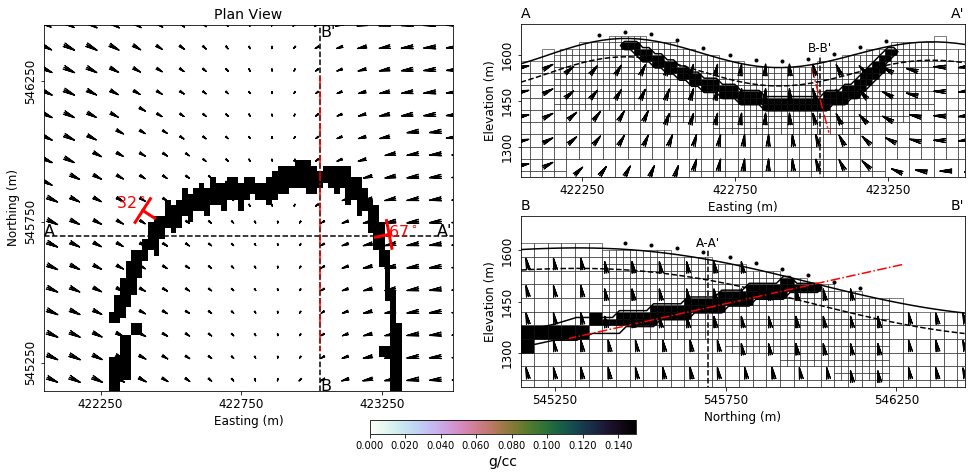

In [32]:
# fig, axs = plt.figure(figsize=(16,8)), plt.subplot()
fig = plt.figure(figsize=(14,8))

indz = 2
indy = int(mesh3D.nCy/2)-6
indx = int(mesh3D.nCx/2)+12

xlim = [422050, 423500]
ylim = [545150, 546450]
zlim = [1000, 1600]

x = [422250, 422750, 423250]
y = [545250, 545750, 546250]
z = [1300, 1450, 1600]

airc = np.ones(mesh.nC, dtype='bool')
airc[actv] = 0
mout[airc,:] = 0

axs = plt.subplot(1,2,1)
modelTop = modelTree[indTop][indModel]

plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCz[indz], 
                      axs=axs, scale=6., 
                      lims=[xlim, ylim], 
                      color='k', resolution=80, normal='Z', 
                      actvMap=actvMap, zorder=3)


mesh.plotSlice(modelTop, normal = 'Z',ind=int(np.searchsorted(mesh.vectorCCz, 1480)), pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)
#     axs, im, cbar = plotModelSections(mesh, mplot, actv = actv, normal='z',subFact=subFact, scale=scale, ind=indz, cmap='pink_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
# plotTopo(topo, axs=axs, fill=False)
plotMarkers(pts, azm, dip, ms = 50, color='r')
# plt.scatter(survey.srcField.rxList[0].locs[:,0],survey.srcField.rxList[0].locs[:,1], 5, color='k')

plt.plot(xlim, [mesh3D.vectorCCy[int(indy)], mesh3D.vectorCCy[int(indy)]], c='k', linestyle='--')
plt.text(xlim[0],mesh3D.vectorCCy[int(indy)],'A', fontsize = 16)
plt.text(xlim[1],mesh3D.vectorCCy[int(indy)],"A'", fontsize = 16, ha = 'right')
plt.plot([mesh3D.vectorCCx[int(indx)], mesh3D.vectorCCx[int(indx)]], ylim, c='k', linestyle='--')
plt.text(mesh3D.vectorCCx[int(indx)], ylim[0],'B', fontsize = 16)
plt.text(mesh3D.vectorCCx[int(indx)], ylim[1],"B'", fontsize = 16, va = 'top')

# Plot fold axis
plt.plot(foldVec[:,0], foldVec[:,1], ylim, c='r', linestyle='-.')

axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
axs.set_xlabel('Easting (m)', size=12)
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
axs.set_ylabel('Northing (m)', size=12)
pos = axs.get_position()
axs.set_aspect('equal')
axs.set_position([pos.x0-0.05, pos.y0-0.01,  pos.width*1.15, pos.height*1.15])
axs.set_title('Plan View', fontsize=14)

axs = plt.subplot(2,2,2)
#     axs, im, cbar = plotModelSections(mesh, mplot, normal='y', actv = actv,subFact=subFact, scale=scale, ind=indy, cmap='pink_r', axs=axs,xlim=xlim, ylim=zlim, vmin=vmin, vmax=vmax)

plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCy[indy], 
                      axs=axs, scale=6., 
                      lims=[xlim, zlim], 
                      color='k', resolution=80, normal='Y', 
                      actvMap=actvMap, zorder=3)

im = mesh.plotSlice(modelTree, normal='Y', 
               ind=int(np.searchsorted(mesh.vectorCCy, mesh3D.vectorCCy[indy])), 
               grid=True, pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)
plotModelSections(mesh3D, model,normal='y', actv = actv3D, ind=indy, cmap='pink_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

# plotModelSections(mesh, theta, phi, normal='y', ind=indy,subFact=4, scale=7., cmap='pink_r', axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

topodrapped = topo.copy()
topodrapped[:,-1] -= np.sum(mesh.hz[-indz-1:])

plotProfile(topo, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')

plot(np.r_[mesh3D.vectorCCx[indx], mesh3D.vectorCCx[indx]], zlim, 'k--')
text(mesh3D.vectorCCx[indx], zlim[1],"B-B'", va='bottom', ha='center', size=12)
plotProfile(topodrapped, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k--')

plotProfile(survey.srcField.rxList[0].locs, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         18, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k.')
# Plot fold axis
Rx = np.vstack(
    (np.r_[np.cos(np.deg2rad(15)), -np.sin(np.deg2rad(15))],
     np.r_[np.sin(np.deg2rad(15)), np.cos(np.deg2rad(15))])
)

line = np.dot(Rx, np.c_[foldVec[:,0]-x0,foldVec[:,2]-z0].T )


plt.plot(line[0,:]+x0, line[1,:]+z0, c='r', linestyle='-.')

#     cbar.remove()
axs.set_xlabel('Easting (m)', size=12)
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
axs.set_yticks(list(map(int, z)))
axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0,  pos.width*1.25, pos.height*1.25])
axs.set_title('A',loc='left', fontsize=14)
axs.set_title("A'",loc='right', fontsize=14)
axs.set_title("",loc='center', fontsize=14)


# NS PROFILE #
axs = plt.subplot(2,2,4)

#     axs, im, cbar = plotModelSections(mesh, mplot, normal='x', actv = actv, ind=indx, cmap='pink_r',subFact=subFact, scale=scale, axs=axs,xlim=ylim, ylim=zlim, vmin=vmin, vmax=vmax)
# im = mesh.plotSlice(mplot, 
#                ind=int(np.searchsorted(mesh.vectorCCx, mesh3D.vectorCCx[indx])),
#                normal='X', pcolorOpts={"cmap":'cubehelix_r'}, grid=True, ax=axs)

plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCx[indx], 
                      axs=axs, scale=6., 
                      lims=[ylim, zlim], 
                      color='k', resolution=80, normal='X', 
                      actvMap=actvMap, zorder=3)
im = mesh.plotSlice(modelTree, normal='X', 
               ind=int(np.searchsorted(mesh.vectorCCx, mesh3D.vectorCCx[indx])), 
               grid=True, pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)

plotModelSections(mesh3D, model,normal='x',actv = actv3D, ind=indx, contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)
# plotModelSections(mesh, mkvc(rz1), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', axs=axs, vmin=0. ,vmax=0.1, fill=False)

# plotModelSections(mesh, mkvc(mout), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

plot(np.r_[mesh3D.vectorCCy[indy], mesh3D.vectorCCy[indy]], zlim, 'k--')
text(mesh3D.vectorCCy[indy], zlim[1],"A-A'", va='bottom', ha='center', size=12)
plotProfile(topo, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k')

plotProfile(topodrapped, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k--')

plotProfile(survey.srcField.rxList[0].locs, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         18, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k.')
# Plot fold axis
plt.plot(foldVec[:,1], foldVec[:,2], ylim, c='r', linestyle='-.')

#     cbar.remove()
axs.set_xlabel('Northing (m)', size=12)
axs.set_xticks(list(map(int, y)))
axs.set_xticklabels(map(str, map(int, y)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
axs.set_yticks(list(map(int, z)))
axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0+0.06,  pos.width*1.25, pos.height*1.25])
axs.set_title('B',loc='left', fontsize=14)
axs.set_title("B'",loc='right', fontsize=14)
axs.set_title("",loc='center', fontsize=14)


axbar = plt.axes([pos.x0-0.15, pos.y0-0.025,  pos.width*.75, pos.height*.75])
cbar = plt.colorbar(im[0], orientation='horizontal',format='%.3f')
# cbar.set_ticks(np.linspace(-.0,0.1,4))
cbar.set_label("g/cc", size=14)
#     axbar.text(pos.x0+0.5, pos.y0-.45,'g/cc', size=14)
axbar.axis('off')

plt.savefig(work_dir + 'InterpolatedDip.png', bbox_inches='tight', dpi=300)

In [105]:
theta[actv].min(), phi[actv].min(), theta[actv].max(), phi[actv].max()


NameError: name 'theta' is not defined

In [106]:
# # Test two type of minimum curvatures

# # Relaxation method

# # PDE method
# import scipy.sparse as sp

# # Create a Laplacian operator
# mesh.setCellGradBC('neumann')
# G = mesh.cellGrad
# D = mesh.faceDiv
# A = G.T*G#sp.vstack([G.T*G,G])

# ind = np.zeros(mesh.nC, dtype='bool')
# for ii in mesh.cellBoundaryInd: ind = ind | ii

# # Get the grid location
# ijk = Utils.meshutils.closestPoints(mesh, pts, gridLoc='CC')
# ijk = np.r_[ijk, ind]
# nC = len(ijk)

# Z = sp.csr_matrix((len(ijk),len(ijk)))
# # Diagonal matrix to zero out the gradient on the fix cells
# P = speye(mesh.nC)


# P = P[ijk,:]

# H = sp.vstack([sp.hstack([A.T*A, P.T]),sp.hstack([P,Z])])
# # A = Pac * A * Pac

# # Create pre-conditioner for speedup
# # dA = A.diagonal()
# # P = sp.spdiags(1/dA,0,A.shape[0],A.shape[0])
# mrx = []
# for ii in range(rx.shape[1]):
    
    
#     BC = np.r_[np.zeros(mesh.nC),np.r_[rx[:,ii],np.zeros_like(ind)]]

#     mrx += [sp.linalg.spsolve(H,BC)]

In [41]:
from SimPEG.Utils import speye, kron3
nC = int(actv.sum())

# nC = prob.F.shape[1]

# wr = np.zeros(nC)
# for ii in range(survey.nD):
#     wr += (prob.F[ii, :])**2.
wr = prob.getJtJdiag(np.zeros(nC))
wr = (wr/np.max(wr)) 
wr = wr**0.5


prob.unpair()
survey.pair(prob)

#actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg1.norms = np.c_[0., 1, 1, 1]
# reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
# reg1.alpha_z = 3
# reg1.eps_p = 1e-3
# reg1.eps_q = 1e-3
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
reg1.mref = np.zeros(nC)

# reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
# reg1.objfcts[1].regmesh._aveCC2Fx = speye(nC)

# reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
# reg1.objfcts[2].regmesh._aveCC2Fy = speye(nC)

# reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
# reg1.objfcts[3].regmesh._aveCC2Fz = speye(nC)

# reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
# reg2.norms = [0., 2, 2, 0]
# # reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# # reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
# # reg1.alpha_z = 3
# reg2.eps_p = 1e-3
# reg2.eps_q = 1e-3
# reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
# reg2.mref = np.zeros(nC)


# reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
# reg2.objfcts[1].regmesh._aveCC2Fx = speye(nC)

# reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
# reg2.objfcts[2].regmesh._aveCC2Fy = speye(nC)

# reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
# reg2.objfcts[3].regmesh._aveCC2Fz = speye(nC)

reg= reg1# + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=40, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1e0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=30, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
prob.model = m0
mrec = inv.run(m0)
m_l2 = invProb.l2model

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

Use Simple
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.17e+09  9.29e+06  9.60e-07  9.29e+06    2.46e+02      0              
Start CG solve
CG solve time: 17.408010244369507
   1  5.86e+08  1.55e+06  1.36e-03  2.35e+06    2.46e+02      0              
Start CG solve
CG solve time: 17.108840227127075
   2  2.93e+08  9.55e+05  2.07e-03  1.56e+06    2.45e+02      0   Skip BFGS  
Start CG solve
CG solve time: 18.290695905685425
   3  1.46e+08  5.71e+05  2.99e-03  1.01e+06    2.45e+02      0   Skip BFGS  
Start CG solve
CG solve time: 17.406224250793457
   4  7.32e+07  3.32e+05  4.14e-03  6.35e+05    2.45e+02      0   Skip BFGS  
Start CG sol

In [ ]:
# Mesh.TensorMesh.writeModelUBC(mesh,work_dir + 'SimPEG_Gravl2.den', actvMap *IRLS.l2model)

In [ ]:
# mvec = mout
# mvec[:,-1] *= -1.
# modelMatTR = np.zeros_like(mvec)

# model[model==-100] = 0
# # mvec = Utils.sdiag(model)*mvec
# for ii in range(3):
#     # Reshape model to a matrix
#     modelMat = mesh.r(mvec[:, ii], 'CC', 'CC', 'M')
#     # Transpose the axes
#     modelMatT = modelMat.transpose((2, 0, 1))
#     # Flip z to positive down
#     modelMatTR[:, ii] = Utils.mkvc(modelMatT[::-1, :, :])

# np.savetxt(work_dir + 'Normal.fld', modelMatTR)

In [ ]:
invProb.model.max()

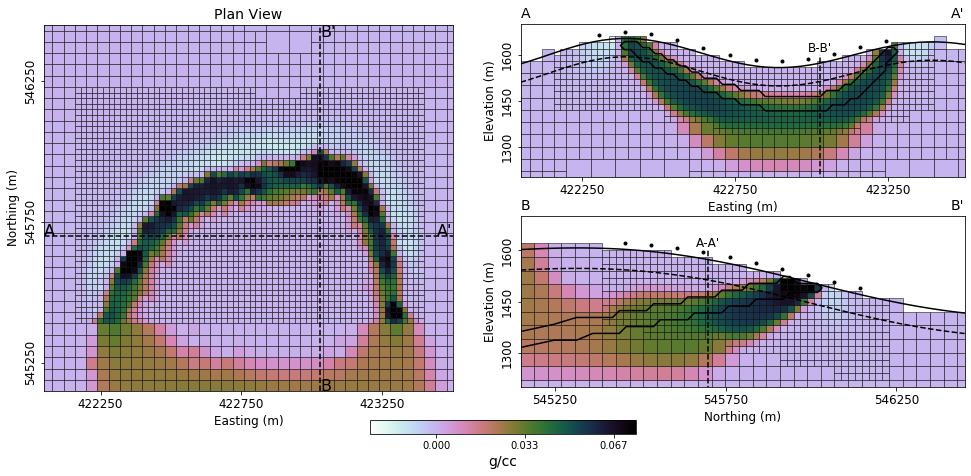

In [42]:
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)
fileName = work_dir + 'GRAV_Synthetic_l0l2.png'
plot3Panels(actvMap*invProb.model,fileName, vmin=-.025, vmax=.075, plotMarker=False)


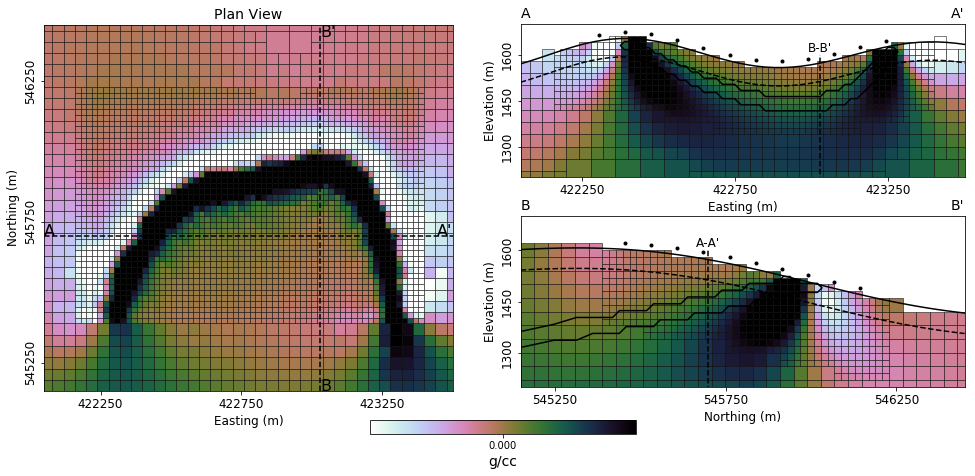

In [19]:

fileName = work_dir+'GRAV_Synthetic_l2l2.png'
plot3Panels(actvMap*invProb.l2model,fileName, vmin=-.025, vmax=.025, plotMarker=False)


In [39]:
from SimPEG.Utils import speye, kron3
nC = int(actv.sum())

wr = prob.getJtJdiag(np.zeros(nC))
wr = (wr/np.max(wr)) 
wr = wr**0.5



prob.unpair()
survey.pair(prob)

#actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap,
                            gradientType='total')
reg1.norms = np.c_[0., 2, 2, 0]
# reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
reg1.alpha_z = 4
reg1.alpha_y = 1
reg1.alpha_s = 1
# reg1.eps_p = 1e-3
# reg1.eps_q = 1e-3
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
reg1.mref = np.zeros(nC)

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
# reg1.objfcts[1].regmesh._aveCC2Fx = speye(nC)
I,J,_= sp.sparse.find(Dx1)
reg1.objfcts[1].regmesh._aveCC2Fx = sp.sparse.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dx1.shape))

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
# reg1.objfcts[2].regmesh._aveCC2Fy = speye(nC)
I,J,_= sp.sparse.find(Dy1)
reg1.objfcts[2].regmesh._aveCC2Fy = sp.sparse.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dy1.shape))


reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
# reg1.objfcts[3].regmesh._aveCC2Fz = speye(nC)
I,J,_= sp.sparse.find(Dz1)
reg1.objfcts[3].regmesh._aveCC2Fz = sp.sparse.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dz1.shape))


reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap,
                            gradientType='total')
reg2.norms = np.c_[0., 2, 2, 0]
# reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
reg2.alpha_z = 4
reg2.alpha_y = 1
reg2.alpha_s = 1
# reg2.eps_p = 1e-3
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
reg2.mref = np.zeros(nC)


reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
# reg2.objfcts[1].regmesh._aveCC2Fx = speye(nC)
I,J,_= sp.sparse.find(Dx2)
reg2.objfcts[1].regmesh._aveCC2Fx = sp.sparse.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dx2.shape))

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
# reg2.objfcts[2].regmesh._aveCC2Fy = speye(nC)
I,J,_= sp.sparse.find(Dy2)
reg2.objfcts[2].regmesh._aveCC2Fy = sp.sparse.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dy2.shape))

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
# reg2.objfcts[3].regmesh._aveCC2Fz = speye(nC)
I,J,_= sp.sparse.find(Dz2)
reg2.objfcts[3].regmesh._aveCC2Fz = sp.sparse.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dz2.shape))


reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=50, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=4e+4)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1e0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=50, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(int(actv.sum()))*1e-4  # Starting model
prob.model = m0
mrec_ROT = inv.run(m0)
m_l2_ROT = invProb.l2model

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

Use Simple
Use Simple
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.00e+04  9.04e+06  3.08e-06  9.04e+06    2.46e+02      0              
Start CG solve
CG solve time: 40.87000322341919
   1  2.00e+04  1.68e+03  1.07e-01  3.83e+03    2.42e+02      0              
Start CG solve
CG solve time: 40.585999965667725
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.10481999129971262 eps_q: 0.10481999129971262
eps_p: 0.10481999129971262 eps_q: 0.10481999129971262
delta phim:    nan
   2  1.00e+04  4.31e+02  2.77e-01  3.20e+03    2.44e+02      0   Skip BFGS  
Start CG solve
CG solve time: 40.85590744018555
delta p

KeyboardInterrupt: 

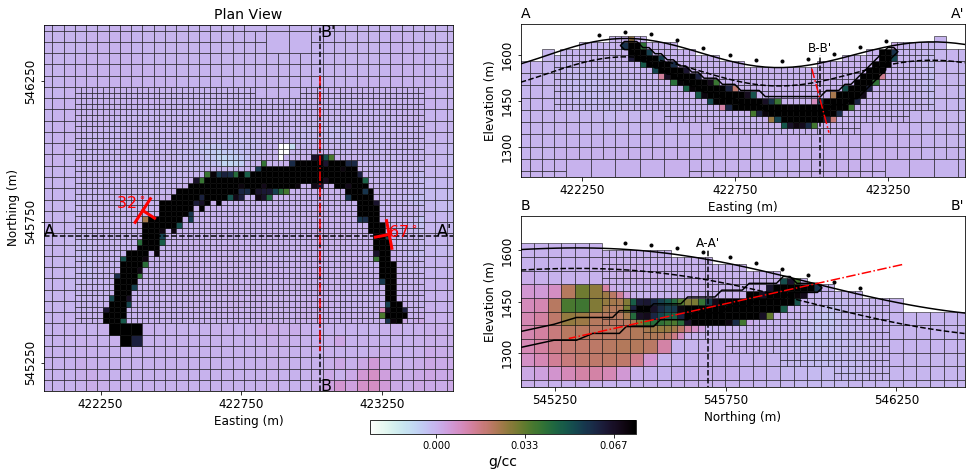

In [40]:
fileName = 'GRAV_Synthetic_ROTl0220.png'
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)
plot3Panels(actvMap*invProb.model,fileName, vmin=-0.025, vmax=.075)
actvOut = Maps.InjectActiveCells(mesh, actv, -100)
Mesh.TreeMesh.writeUBC(mesh, 'MeshOctree.msh', models={'Model_Rotl0l2l0.den':actvOut*invProb.model})

In [39]:
# Repeat inversion over range of dips
models = []
models_l2 = []
out_dir = "TopoFold_varRotation"
for tt in np.linspace(-90,75,12).tolist():

    if tt < 75:
        continue
        
    nC = mesh.nC
    atp = Utils.matutils.xyz2atp(mout)
    phi = atp[2*nC:] 
    theta = np.ones_like(phi) * tt 




    indActive = np.zeros(mesh.nC, dtype=bool)
    indActive[actv] = True

    Pac = Utils.speye(mesh.nC)[:, indActive]

    Dx1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X')
    Dy1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y')
    Dz1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z')

    Dx1 = Pac.T * Dx1 * Pac
    Dy1 = Pac.T * Dy1 * Pac
    Dz1 = Pac.T * Dz1 * Pac


    Dx2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False)
    Dy2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False)
    Dz2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False)

    Dx2 = Pac.T * Dx2 * Pac
    Dy2 = Pac.T * Dy2 * Pac
    Dz2 = Pac.T * Dz2 * Pac

    
    nC = int(actv.sum())

    wr = prob.getJtJdiag(np.zeros(nC))
    wr = (wr/np.max(wr)) 
    wr = wr**0.5



    prob.unpair()
    survey.pair(prob)

    #actv = np.ones(mesh.nC, dtype='bool')
    # Create a regularization
    reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap,
                                gradientType='total')
    reg1.norms = np.c_[0., 2, 2, 0]
    # reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
    # reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
    reg1.alpha_z = 4
    reg1.alpha_y = 1
    reg1.alpha_s = 1
    # reg1.eps_p = 1e-3
    # reg1.eps_q = 1e-3
    reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
    reg1.mref = np.zeros(nC)

    reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
    reg1.objfcts[1].regmesh._aveCC2Fx = speye(nC)

    reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
    reg1.objfcts[2].regmesh._aveCC2Fy = speye(nC)

    reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
    reg1.objfcts[3].regmesh._aveCC2Fz = speye(nC)

    reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap,
                                gradientType='total')
    reg2.norms = np.c_[0., 2, 2, 0]
    # reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
    # reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
    reg2.alpha_z = 4
    reg2.alpha_y = 1
    reg2.alpha_s = 1
    # reg2.eps_p = 1e-3
    reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
    reg2.mref = np.zeros(nC)


    reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
    reg2.objfcts[1].regmesh._aveCC2Fx = speye(nC)

    reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
    reg2.objfcts[2].regmesh._aveCC2Fy = speye(nC)

    reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
    reg2.objfcts[3].regmesh._aveCC2Fz = speye(nC)

    reg= reg1 + reg2

    # Data misfit function
    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./survey.std

    # Add directives to the inversion
    opt = Optimization.ProjectedGNCG(maxIter=50, lower=-1., upper=1.,
                                     maxIterLS=20, maxIterCG=20, tolCG=1e-4)
    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=4e+4)
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1e0)

    # Here is where the norms are applied
    # Use pick a treshold parameter empirically based on the distribution of
    #  model parameters
    IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=50, betaSearch=False)
    update_Jacobi = Directives.UpdatePreconditioner()
    saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap, fileName=out_dir + "\\GRAV_Tile_Theta" + str(int(tt)))

    inv = Inversion.BaseInversion(invProb,
                                  directiveList=[saveModel, IRLS, update_Jacobi])

    # Run the inversion
    m0 = np.ones(int(actv.sum()))*1e-4  # Starting model
    prob.model = m0
    models += [inv.run(m0)]
    models_l2 += [invProb.l2model]

    # Create active map to go from reduce set to full
    actvMap = Maps.InjectActiveCells(mesh, actv, -100)


Use Simple
Use Simple
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.SaveModelEveryIteration will save your models in UBC format as: '###-TopoFold_varRotation\GRAV_Tile_Theta75.mod'
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.00e+04  9.37e+06  2.80e-06  9.37e+06    2.46e+02      0              
Start CG solve
CG solve time: 30.89034652709961
   1  2.00e+04  2.38e+03  7.96e-02  3.97e+03    2.38e+02      0              
Start CG solve
CG solve time: 31.093569040298462
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.1124530532090171 eps_q: 0.1124530532090171
eps_p: 0.1124530532090171 eps_q: 0.1124530532090171
delta phim:    nan
   2  1.00e+04  4

KeyboardInterrupt: 

In [13]:
# Load all results and plot
mesh = Mesh.TreeMesh.readUBC("TopoFold_varRotation\\GRAV_Tile_Theta0.msh")

r, ind = tree3D.query(mesh.gridCC)

modelTree = model[ind]
modelTree[modelTree==-100] = np.nan

In [34]:
models = []
ang = np.linspace(-90,75,12).tolist()
for tt in np.linspace(-90,75,12).tolist():
    
    models += [mesh.readModelUBC("TopoFold_varRotation\\GRAV_Tile_Theta" + str(int(tt)) + ".mod")]

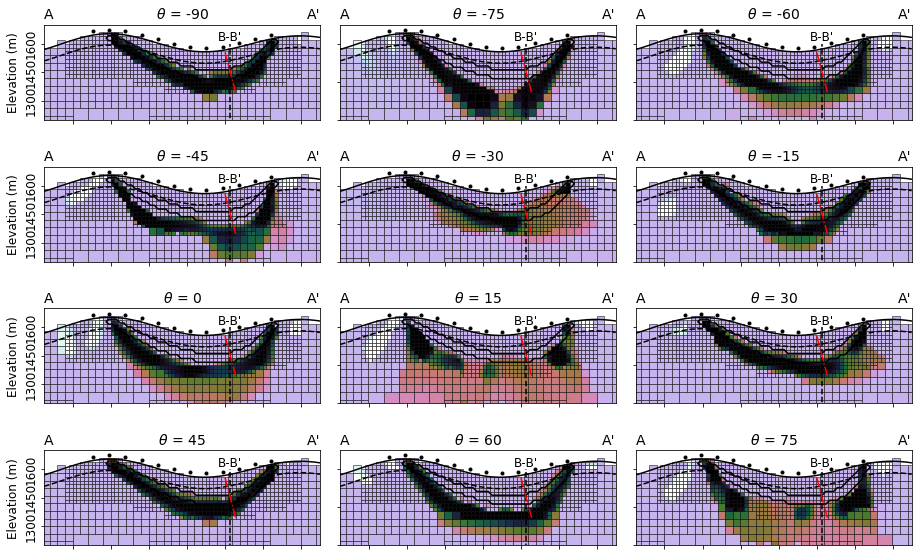

In [41]:
fig = plt.figure(figsize=(14,10))

vmin=-0.025
vmax=.075
for ii, m in enumerate(models):
    
    m[m==-100] = np.nan
    axs = plt.subplot(4,3,ii+1)
#     axs, im, cbar = plotModelSections(mesh, mplot, normal='y', actv = actv,subFact=subFact, scale=scale, ind=indy, cmap='pink_r', axs=axs,xlim=xlim, ylim=zlim, vmin=vmin, vmax=vmax)

#     plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCy[indy], 
#                           axs=axs, scale=6., 
#                           lims=[xlim, zlim], 
#                           color='k', resolution=80, normal='Y', 
#                           actvMap=actvMap, zorder=3)

    im = mesh.plotSlice(m, normal='Y', 
                   ind=int(np.searchsorted(mesh.vectorCCy, mesh3D.vectorCCy[indy])), 
                   grid=True, pcolorOpts={"cmap":'cubehelix_r', "clim":[vmin, vmax], 'vmin':vmin, 'vmax':vmax}, ax=axs)
    plotModelSections(mesh3D, model,normal='y', actv = actv3D, ind=indy, cmap='pink_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

    # plotModelSections(mesh, theta, phi, normal='y', ind=indy,subFact=4, scale=7., cmap='pink_r', axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

    topodrapped = topo.copy()
    topodrapped[:,-1] -= np.sum(mesh.hz[-indz-1:])

    plotProfile(topo, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                             50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                             plotStr='k')

    plot(np.r_[mesh3D.vectorCCx[indx], mesh3D.vectorCCx[indx]], zlim, 'k--')
    text(mesh3D.vectorCCx[indx], zlim[1],"B-B'", va='bottom', ha='center', size=12)
    plotProfile(topodrapped, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                             50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                             plotStr='k--')

    plotProfile(survey.srcField.rxList[0].locs, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                             18, ax=axs, fig=fig, coordinate_system = 'xProfile',
                             plotStr='k.')
    # Plot fold axis
    Rx = np.vstack(
        (np.r_[np.cos(np.deg2rad(15)), -np.sin(np.deg2rad(15))],
         np.r_[np.sin(np.deg2rad(15)), np.cos(np.deg2rad(15))])
    )

    line = np.dot(Rx, np.c_[foldVec[:,0]-x0,foldVec[:,2]-z0].T )


    plt.plot(line[0,:]+x0, line[1,:]+z0, c='r', linestyle='-.')

    #     cbar.remove()
    
    if (ii % 3) == 0:
        
        axs.set_ylabel('Elevation (m)', size=12)
        axs.set_yticks(list(map(int, z)))
        axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
#     pos = axs.get_position()
    else:
        
        axs.set_ylabel("")
        axs.set_yticklabels([])

    if ii in [12, 13, 14]:
        axs.set_xlabel('Easting (m)', size=12)
        axs.set_xticks(list(map(int, x)))
        axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
    else:
        axs.set_xlabel("")
        axs.set_xticklabels([])
        
    pos=axs.get_position()
    if ii in np.arange(1,13,3).tolist():
        axs.set_position([pos.x0, pos.y0,  pos.width*1.2, pos.height*1.2])
       
    elif ii in np.arange(2,13,3).tolist():
        axs.set_position([pos.x0+.02, pos.y0,  pos.width*1.2, pos.height*1.2])
    else:
        axs.set_position([pos.x0-0.02, pos.y0,  pos.width*1.2, pos.height*1.2])
        
#     pos=axs.get_position()
    
    axs.set_title('A',loc='left', fontsize=14)
    axs.set_title("A'",loc='right', fontsize=14)
    axs.set_title("$\\theta$ = %i" % ang[ii],loc='center', fontsize=14)

plt.savefig(work_dir + 'GRAV_ModelSpace_Dip.png', bbox_inches='tight', dpi=300)

In [39]:
np.arange(1,13,3)



array([ 1,  4,  7, 10])

In [48]:
# Find top layer
indTop = Utils.modelutils.activeTopoLayer(mesh, topo, index=4)

# Propagate to top
treeTop = cKDTree(mesh.gridCC[indTop,:2])

r, indModel = treeTop.query(mesh.gridCC[:,:2])

# modelTop = modelTree[indTop][indModel]

In [49]:
tree = cKDTree(mesh.gridCC)

In [5]:
# Apply the PCA to entire model
mstack = []
# Load all results and plot
mesh = Mesh.TreeMesh.readUBC("TopoFold_varRotation\\GRAV_Tile_Theta0.msh")
tree = cKDTree(mesh.gridCC)
ang = np.linspace(-90,75,12).tolist()
for tt in np.linspace(-90,75,12).tolist():
    m = mesh.readModelUBC("TopoFold_varRotation\\GRAV_Tile_Theta" + str(int(tt)) + ".mod")
    mstack += [m[m!=-100]]
    
actv = m!=-100
actvMap = Maps.InjectActiveCells(mesh, actv, 0)

In [8]:
from sklearn.decomposition import PCA
vmin = 0
vmax = 0.1
A = np.vstack(mstack).T

pca = PCA(n_components = 4)
model_pca = pca.fit_transform(A)
# subplot(2, 2, 2)
# io.imshow(coke_gray_pca)
# xlabel('Image after applying PCA')
model_restored = pca.inverse_transform(model_pca)
print('Variance retained %s %%' %(
    (1 - sum(pca.explained_variance_ratio_) / 
     len(pca.explained_variance_ratio_)) * 100)
)

score = mkvc(pca.components_).tolist()

mPCA = np.zeros_like(mstack[0])
weights = 0
for ii in range(pca.components_.shape[0]):
    
    score = mkvc(pca.components_[ii,:]).tolist()
    for mm, (w, m) in enumerate(zip(score, mstack)):

        if w > 0:
            mPCA += w*model_restored[:,mm]
            weights += w

mPCA /= np.sum(weights)

fileName = 'GRAV_Synthetic_mPCA.png'
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)
plot3Panels(actvMap*mPCA,fileName, vmin=-0.025, vmax=.075, plotMarker=False)


Variance retained 77.70090410673942 %


NameError: name 'mesh3D' is not defined

<Figure size 1008x576 with 0 Axes>

In [7]:
def raw_moment(data, i_order, j_order):
    nrows, ncols = data.shape
    y_indices, x_indicies = np.mgrid[:nrows, :ncols]
  
    return (data * x_indicies**i_order * y_indices**j_order).sum()

def moments_cov(data):
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_centroid = m10 / data_sum
    y_centroid = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    return [x_centroid, y_centroid], cov



# Demo image moment

In [8]:
ubc = np.flipud(1-plt.imread("UBClogo.png")[:,:,0])


In [9]:
m.size



NameError: name 'm' is not defined

In [98]:
from skimage import feature

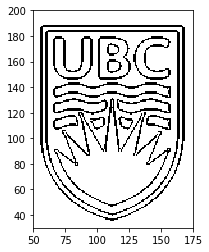

In [105]:
model = feature.canny(ubc > threshold, sigma=0.1)

ax2 = plt.subplot()
plt.imshow(model, cmap='gray_r', origin='lower')

ax2.set_xlim([50,175])
ax2.set_ylim([30,200])
ax2.set_aspect('equal')

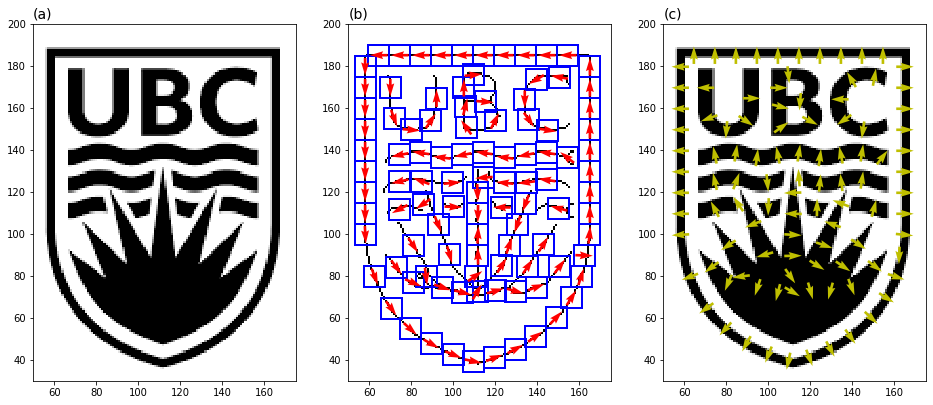

In [117]:
fig = plt.figure(figsize=(16,16))
ax1 = plt.subplot(1,3,1)
plt.imshow(ubc, cmap='gray_r', origin='lower')

ax1.set_xlim([50,175])
ax1.set_ylim([30,200])
ax1.set_aspect('equal')
ax1.set_title("(a)", loc='left', size=14)

winSize = 5
threshold = 0.5
dl = 20

X, Z = mkvc(np.arange(55, 200, 5)), mkvc(np.arange(40, 190, 5))# np.r_[58,70,110,125,140, 160, 170, 200], np.r_[40, 60, 110, 125, 135,150,160, 176, 188]#np.c_[140, 160]#, mkvc(np.linspace(20, 200, 6))# 
model = skeletonize(ubc > threshold)

# model = feature.canny(ubc > threshold, sigma=0.1)
ax2 = plt.subplot(1,3,2)
plt.imshow(model, cmap='gray_r', origin='lower')

ax2.set_xlim([50,175])
ax2.set_ylim([30,200])
ax2.set_aspect('equal')
ax2.set_title("(b)", loc='left', size=14)

vec = np.c_[1.,1e-6]
vecs = []

for ii in range(X.shape[0]):
    
    for jj in range(Z.shape[0]):

#         subx, suby = np.arange(, int(X[ii])+winSize), np.arange(int(Z[jj])-winSize, int(Z[jj])+winSize)
        if len(vecs) > 0:
            newTree = cKDTree(np.vstack(vecs)[:,:2])
            dist, ind = newTree.query(np.c_[X[ii],Z[jj]], 1)

            if dist < winSize:
                continue
            
            vec = vecs[ind[0]][2:]
#             print(vec)
            
        flag = 1
        count = 1
        x, z = X[ii], Z[jj]
        while flag == 1:
            m = model[(int(z)-winSize):(int(z)+winSize), (int(x)-winSize):(int(x)+winSize)] 

            if (m.sum() < m.size/12) or (m.sum() > (m.size*.95)):
                flag = 0
                continue


            center, cov = moments_cov(m)

            if not np.any(np.isnan(cov)):
                

                evals, evecs = np.linalg.eig(cov)

                center_x = int(x) - winSize + center[0] 

                center_y = int(z) - winSize + center[1] 
                
                ind = np.argmax(np.abs(evals))

                # Flip the vector if opposite to previous
                vec_new = evecs[ind]
                vec_new[1] *= -1
                sign = np.sign(np.dot(vec, vec_new))
                if sign==0:
                    sign=-1
                vec = sign*vec_new.copy()
                val = evals[ind]
    #             ax2.contourf(subx, suby, m)
                

#                 normal = np.dot(np.r_[np.c_[0, 1], np.c_[-1,0]], vec)
#                 normal /= np.linalg.norm(normal)
    #             ax2.quiver(center_x, center_y, 
    #                       normal[0], 
    #                       normal[1], color='b', width=0.005, zorder=3)

                # Find next position
                x, z = center_x + vec[0] * winSize * 1., center_y + vec[1] * winSize * 1.
                
                # Check if the next position is the end of a line
                if (x > ubc.shape[0]) or (x < 0) or (z > ubc.shape[0]) or (z < 0):
#                     print("End of line")
                    flag = 0

                # Check if the next position has the pixel count
                m = model[(int(z)-winSize):(int(z)+winSize), (int(x)-winSize):(int(x)+winSize)] 

                if (m.sum() < m.size/20) or (m.sum() > m.size*.90):
#                     print("Not enough pixels")
                    flag = 0
                    
                # Check if not overlapping with existing vector
                dist, ind = newTree.query(np.c_[x, z], 1)

                if dist < winSize:
#                     print("Too close")
                    flag = 0
                    
                # If single entry than skip
                if (count == 1) and (flag == 0):
                    continue
                    
                # Else store and continue
                count += 1
                vecs += [np.r_[center_x, center_y, vec]]
        
                model[(int(center_y)-winSize):(int(center_y)+winSize), (int(center_x)-winSize):(int(center_x)+winSize)] = False
                
                # Plot the vector and box
                ax2.quiver(center_x, center_y, 
                          vec[0], 
                          vec[1], color='r', pivot='middle', width=0.01, scale=15, zorder=3)

                rec = Rectangle(np.r_[center_x-winSize, center_y-winSize], 2*winSize, 2*winSize,
                                facecolor='none', edgecolor='b', linewidth=2, zorder=2)
                ax2.add_patch(rec)
            
# ax3 = plt.subplot(1, 3, 3)
# # skeleton = skeletonize(ubc>threshold)
# cntr = plt.imshow(ubc, cmap='gray_r', origin='lower')

# ax3.set_xlim([50,175])
# ax3.set_ylim([30,200])
# ax3.set_aspect('equal')
vecs = np.vstack(vecs)

# Loop through the vectors and re-oriente
# treeVec = cKDTree(vecs[:,:2])
nn = 4

normals = []
# for kk in range(3):
for ii in range(vecs.shape[0]):



#     dist, ind = treeVec.query(vecs[ii,:2], nn)

#     # Compute the median orientation of neighbours
#     theta = np.mean(np.arctan2(np.c_[vecs[ind[1:],3]], np.c_[vecs[ind[1:],2]]))

#     # If deviates more than 90, flip the vector
#     if np.abs(np.arctan2(vecs[ii,3], vecs[ii,2]) - theta) > np.pi/2:
#         vecs[ii,2:]*=-1
    normal = np.dot(np.r_[np.c_[0, 1], np.c_[-1,0]], vecs[ii,2:])
    normal /= np.linalg.norm(normal)
    normals += [normal]
            
# ax3.quiver(vecs[:,0], vecs[:,1], vecs[:,2], vecs[:,3], color='y', pivot='middle', width=0.01, scale=15, zorder=3)


ax4 = plt.subplot(1, 3, 3)
# skeleton = skeletonize(ubc>threshold)
cntr = plt.imshow(ubc, cmap='gray_r', origin='lower')

ax4.set_xlim([50,175])
ax4.set_ylim([30,200])
ax4.set_aspect('equal')
ax4.set_title("(c)", loc='left', size=14)

normals = np.vstack(normals)
ax4.quiver(vecs[:,0], vecs[:,1], normals[:,0], normals[:,1], color='y', pivot='middle', width=0.01, scale=15, zorder=3)


# ax2 = plt.subplot(1, 3, 3)
# plt.imshow(ubc, cmap='gray_r', origin='lower')

# ax2.set_xlim([50,175])
# ax2.set_ylim([30,200])
# ax2.set_aspect('equal')
# Interpolate
# xx, yy = np.meshgrid(np.arange(0, ubc.shape[0],10), np.arange(140, ubc.shape[1],10))
# F = sp.interpolate.interp2d(vecs[:,0], vecs[:,1], vecs[:,2])
# mx = mkvc((F(np.arange(0, ubc.shape[0], 10), np.arange(140, ubc.shape[1], 10)).T))


# F = sp.interpolate.interp2d(vecs[:,0], vecs[:,1], vecs[:,3])
# my = mkvc((F(np.arange(0, ubc.shape[0], 10), np.arange(140, ubc.shape[1], 10)).T))

# # interV = np.c_[mkvc(mx), mkvc(my)]

# interV = sdiag((mx**2. + my**2.)**-0.5) * np.c_[mx, my] * 10

# ax2.quiver(xx, yy, interV[:, 0], interV[:, 1], color='r', pivot='middle', width=0.01, scale=150, zorder=3)


plt.savefig('ImageMoment_UBClogo.png', bbox_inches='tight', dpi=300)

In [89]:
np.arctan2(vecs[ii,3], vecs[ii,2]), theta, np.abs(np.arctan2(vecs[ii,3], vecs[ii,2]) - theta)









(1.5707963267948966, 2.478606735230291, 0.9078104084353944)

In [201]:
dist, ind = newTree.query(np.c_[X[ii],Z[jj]], 1)
X[ii], Z[jj]


(58.0, 130.0)

In [191]:
(x > X.max()) or (x < X.min()) or (z > Z.max()) or (z < Z.min())

    
(x < X.min())


True

In [194]:
x, X





(58.5, array([ 59. ,  69.6,  80.2,  90.8, 101.4, 112. , 122.6, 133.2, 143.8,
        154.4, 165. ]))

array([[-0.8997969,  0.436309 ],
       [-0.436309 ,  0.8997969]])

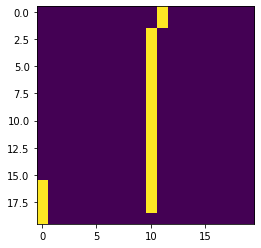

In [192]:

plt.imshow(skeleton)
evecs


0 1


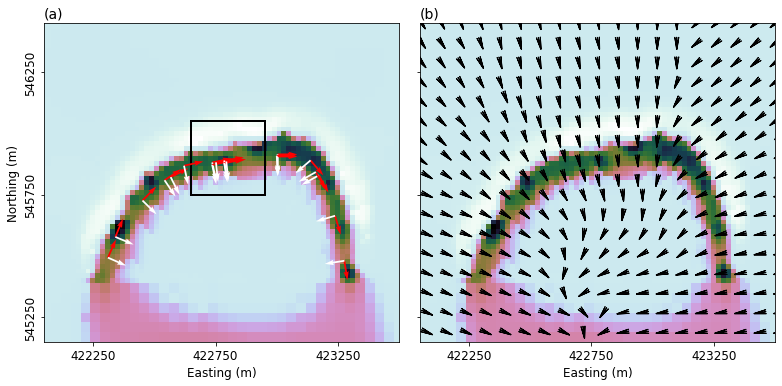

In [68]:
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(14,8))
xlim = [422050, 423500]
ylim = [545150, 546450]
zlim = [1000, 1600]
tree = cKDTree(mesh.gridCC)

x = [422250, 422750, 423250]
y = [545250, 545750, 546250]
z = [1300, 1450, 1600]

winSize = 150
threshold = 0.04
dl = 20
zloc = 1480
# xloc = mesh3D.vectorCCx[indx]

ax1 = plt.subplot(1,2,1)
# modelTop = (actvMap*mPCA)[indTop][indModel]
modelTop = (actvMap*mrec)[indTop][indModel]


mesh.plotSlice(modelTop, 
               normal = 'Z',ind=int(np.searchsorted(mesh.vectorCCz, 1480)), 
               pcolorOpts={"cmap":'cubehelix_r'}, ax=ax1)

X, Z = np.r_[422250, 422550, 422750, 422800, 423000, 423250], np.r_[545450, 545650, 545850, 545900, 546000]#mkvc(np.arange(545450, 546000, 100))
vec = np.c_[1,1]
vecs = []
zloc = 1480
for ii in range(X.shape[0]):
    
    for jj in range(Z.shape[0]):

        subx, suby = np.meshgrid(np.arange(X[ii]-winSize, X[ii]+winSize, dl), np.arange(Z[jj]-winSize, Z[jj]+winSize, dl))

        # Grab nearest model values
        r, indsub = tree.query(np.c_[mkvc(subx), mkvc(suby), np.ones_like(mkvc(subx))*zloc])

        m = modelTop[indsub].reshape(subx.shape, order='F') > threshold
#         skeleton = skeletonize(m)

        center, cov = moments_cov(m)
        
        if not np.any(np.isnan(cov)):
            evals, evecs = np.linalg.eig(cov)

            center_x = np.min(subx) + center[0] * mesh.hx.min()

            center_y = np.min(suby) + center[1] * mesh.hy.min()
            
            ind = np.argmax(np.abs(evals))

            # Flip the vector if opposite to previous
            vec_new = evecs[ind]
            vec_new[1] *= -1
            sign = np.sign(np.dot(vec, vec_new))
            vec = sign*vec_new.copy()
            val = evals[ind]
#             ax1.contourf(subx, suby, m)
            ax1.quiver(center_x, center_y, 
                      vec[0], 
                      vec[1], color='r', width=0.005, zorder=3)
            
            normal = np.dot(np.r_[np.c_[0, 1], np.c_[-1,0]], vec)
            normal /= np.linalg.norm(normal)
            ax1.quiver(center_x, center_y, 
                      normal[0], 
                      normal[1], color='w', width=0.005, zorder=3)
            vecs += [np.r_[center_x, center_y, zloc,  np.r_[normal, np.nan]]]




# Interpolate 2D rotation angles
vecs = np.vstack(vecs)

# Find boundary cells
bcInd = np.unique(np.hstack(mesh.cellBoundaryInd))

# Assign nearest to the boundary 
bcVal = griddata(vecs[:,:3], vecs[:,3:], (mesh.gridCC[bcInd,0], mesh.gridCC[bcInd,1], mesh.gridCC[bcInd,2]), method='nearest')

# Stack to the points
pts = np.vstack([vecs[:,:3], mesh.gridCC[bcInd,:]])
vals = np.vstack([vecs[:,3:], bcVal])

mx = griddata(pts[~np.isnan(vals[:,0]),:], vals[~np.isnan(vals[:,0]),0], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

# rbf = Rbf(pts[::5, 0], pts[::5, 1], pts[::5, 2], vals[::5,1])
my = griddata(pts[~np.isnan(vals[:,1]),:], vals[~np.isnan(vals[:,1]),1], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

# rbf = Rbf(pts[::5, 0], pts[::5, 1], pts[::5, 2], vals[::5,2])
mz = np.zeros_like(my)

mout = sdiag((mx**2. + my**2. + mz**2.)**-0.5) * np.c_[mx, my, mz]

nC = mesh.nC
atp = Utils.matutils.xyz2atp(mout)

theta = atp[nC:2*nC]
phi = atp[2*nC:] 

axs = plt.subplot(1,2,2)
# modelTop = modelTree[indTop][indModel]

plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCz[indz], 
                      axs=axs, scale=6., 
                      lims=[xlim, ylim], 
                      color='k', resolution=80, normal='Z', 
                      actvMap=actvMap, zorder=3)

mesh.plotSlice(modelTop, 
               normal = 'Z',ind=int(np.searchsorted(mesh.vectorCCz, 1480)), 
               pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)
# mesh.plotSlice(modelTop, normal = 'Z',ind=int(np.searchsorted(mesh.vectorCCz, 1480)), pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)
#     axs, im, cbar = plotModelSections(mesh, mplot, actv = actv, normal='z',subFact=subFact, scale=scale, ind=indz, cmap='pink_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
# plotTopo(topo, axs=axs, fill=False)
# plotMarkers(pts, azm, dip, ms = 50, color='r')
# plt.scatter(survey.srcField.rxList[0].locs[:,0],survey.srcField.rxList[0].locs[:,1], 5, color='k')

# plt.plot(xlim, [mesh3D.vectorCCy[int(indy)], mesh3D.vectorCCy[int(indy)]], c='k', linestyle='--')
# plt.text(xlim[0],mesh3D.vectorCCy[int(indy)],'A', fontsize = 16)
# plt.text(xlim[1],mesh3D.vectorCCy[int(indy)],"A'", fontsize = 16, ha = 'right')
# plt.plot([mesh3D.vectorCCx[int(indx)], mesh3D.vectorCCx[int(indx)]], ylim, c='k', linestyle='--')
# plt.text(mesh3D.vectorCCx[int(indx)], ylim[0],'B', fontsize = 16)
# plt.text(mesh3D.vectorCCx[int(indx)], ylim[1],"B'", fontsize = 16, va = 'top')

# Plot fold axis
# plt.plot(foldVec[:,0], foldVec[:,1], ylim, c='r', linestyle='-.')

axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
axs.set_xlabel('Easting (m)', size=12)
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_yticks(list(map(int, y)))
axs.set_yticklabels([],size=12, va='center', rotation=90)
axs.set_ylabel('', size=12)
pos = axs.get_position()
axs.set_aspect('equal')
axs.set_position([pos.x0, pos.y0,  pos.width, pos.height])
axs.set_title('(b)', loc='left', fontsize=14)
axs.set_title('', loc='center', fontsize=14)


# # Repeat process for single tile
Y, X = np.c_[545900], np.c_[422800]
# vec = np.c_[1,1]
# subx, suby = np.meshgrid(np.arange(X-winSize, X+winSize, dl), np.arange(Y-winSize, Y+winSize, dl))

# # Grab nearest model values
# r, indsub = tree.query(np.c_[mkvc(subx), mkvc(suby), np.ones_like(mkvc(subx))*zloc])

# m = modelTop[indsub].reshape(subx.shape, order='F') 
# mlogic = m > threshold
# skeleton = skeletonize(mlogic)

# center, cov = moments_cov(skeleton)

# ax4 = plt.subplot(2,2,2)
# ax5 = plt.subplot(2,2,4)

# if not np.any(np.isnan(cov)):
#     evals, evecs = np.linalg.eig(cov)

#     center_x = np.min(subx) + center[0] * mesh.hx.min()

#     center_y = np.min(suby) + center[1] * mesh.hy.min()

#     ind = np.argmax(np.abs(evals))

#     # Flip the vector if opposite to previous
#     vec_new = evecs[ind]
#     vec_new[1] *= -1
#     sign = np.sign(np.dot(vec, vec_new))
#     vec = sign*vec_new.copy()
#     val = evals[ind]


#     normal = np.dot(np.r_[np.c_[0, 1], np.c_[-1,0]], vec)
#     normal /= np.linalg.norm(normal)
#     ax4.contourf(subx, suby, m, 30, cmap='cubehelix_r')
#     ax4.contour(subx, suby, m,[threshold])

#     ax5.contour(subx, suby, m,[threshold])
#     ax5.contourf(subx, suby, skeleton, 30, cmap='cubehelix_r')
#     ax5.quiver(center_x, center_y, 
#               vec[0], 
#               vec[1], color='r', width=0.02, scale=4, zorder=3)

#     ax5.quiver(center_x, center_y, 
#               normal[0], 
#               normal[1], color='b', width=0.02, scale=4, zorder=3)

#     ax4.set_aspect('equal')
#     ax5.set_aspect('equal')

rec = Rectangle(np.r_[X-winSize, Y-winSize], 2*winSize, 2*winSize,facecolor='none', edgecolor='k', linewidth=2)
ax1.add_patch(rec)
ax1.set_xticks(list(map(int, x)))
ax1.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
ax1.set_xlabel('Easting (m)', size=12)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_yticks(list(map(int, y)))
ax1.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
ax1.set_ylabel('Northing (m)', size=12)
pos = ax1.get_position()
ax1.set_aspect('equal')
ax1.set_position([pos.x0+0.05, pos.y0,  pos.width, pos.height])
ax1.set_title('(a)', loc='left', fontsize=14)
ax1.set_title('', loc='center', fontsize=14)



# y = np.r_[545800, 545875, 545950]
# x = np.r_[422700, 422775, 422850]
# ax4.set_xticks(list(map(int, x)))
# ax4.set_xticklabels([],size=12, ha='center')
# ax4.set_xlabel('', size=12)
# ax4.set_xlim([x.min()-50, x.max()+50])
# ax4.set_ylim([y.min()-50, y.max()+50])
# ax4.set_yticks(list(map(int, y)))
# ax4.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
# ax4.set_ylabel('Northing (m)', size=12)
# pos = ax4.get_position()
# ax4.set_aspect('equal')
# ax4.set_position([pos.x0-0.05, pos.y0+0.01,  pos.width, pos.height])
# ax4.set_title('(b)', loc='left', fontsize=14)

# ax5.set_xticks(list(map(int, x)))
# ax5.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
# ax5.set_xlabel('Easting (m)', size=12)
# ax5.set_xlim([x.min()-50, x.max()+50])
# ax5.set_ylim([y.min()-50, y.max()+50])
# ax5.set_yticks(list(map(int, y)))
# ax5.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
# ax5.set_ylabel('Northing (m)', size=12)
# pos = ax5.get_position()
# ax5.set_aspect('equal')
# ax5.set_position([pos.x0-0.05, pos.y0-0.01,  pos.width, pos.height])
# ax5.set_title('(c)', loc='left', fontsize=14)

plt.savefig(work_dir + 'ImageMoment.png', bbox_inches='tight', dpi=300)

# Compute orientation along EW section

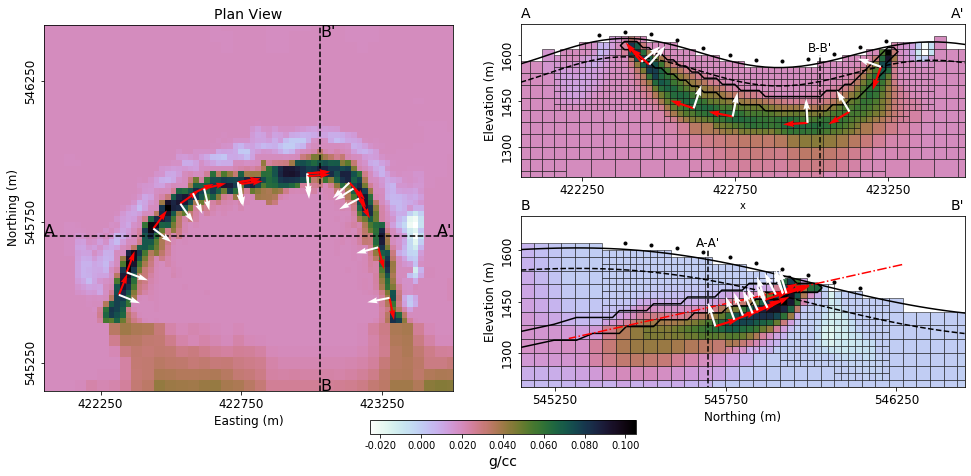

In [47]:
fig = plt.figure(figsize=(14,8))

indz = 2
indy = int(mesh3D.nCy/2)-6
indx = int(mesh3D.nCx/2)+12

xlim = [422050, 423500]
ylim = [545150, 546450]
zlim = [1000, 1600]

x = [422250, 422750, 423250]
y = [545250, 545750, 546250]
z = [1300, 1450, 1600]

actvMapZero = Maps.InjectActiveCells(mesh, actv, 0)
# Create a grid of query points
winSize = 150
dl = 20
threshold = 0.05

ax1 = plt.subplot(1,2,1)
modelTop = (actvMap*mPCA)[indTop][indModel]

# plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCz[indz], 
#                       axs=axs, scale=6., 
#                       lims=[xlim, ylim], 
#                       color='k', resolution=80, normal='Z', 
#                       actvMap=actvMap, zorder=3)


mesh.plotSlice(modelTop, 
               normal = 'Z',ind=int(np.searchsorted(mesh.vectorCCz, 1480)), 
               pcolorOpts={"cmap":'cubehelix_r'}, ax=ax1)

X, Z = np.r_[422250, 422550, 422750, 423000, 423250], np.r_[545450, 545650, 545850, 545950, 546000]#mkvc(np.arange(545450, 546000, 100))
vec = np.c_[1,1]
vecs = []
zloc = 1480
for ii in range(X.shape[0]):
    
    for jj in range(Z.shape[0]):

        subx, suby = np.meshgrid(np.arange(X[ii]-winSize, X[ii]+winSize, dl), np.arange(Z[jj]-winSize, Z[jj]+winSize, dl))

        # Grab nearest model values
        r, indsub = tree.query(np.c_[mkvc(subx), mkvc(suby), np.ones_like(mkvc(subx))*zloc])

        m = modelTop[indsub].reshape(subx.shape, order='F') > threshold
#         skeleton = skeletonize(m)

        center, cov = moments_cov(m)
        
        if not np.any(np.isnan(cov)):
            evals, evecs = np.linalg.eig(cov)

            center_x = np.min(subx) + center[0] * mesh.hx[0]

            center_y = np.min(suby) + center[1] * mesh.hy[0]
            
            ind = np.argmax(np.abs(evals))

            # Flip the vector if opposite to previous
            vec_new = evecs[ind]
            vec_new[1] *= -1
            sign = np.sign(np.dot(vec, vec_new))
            vec = sign*vec_new.copy()
            val = evals[ind]
#             ax1.contourf(subx, suby, m)
            ax1.quiver(center_x, center_y, 
                      vec[0], 
                      vec[1], color='r', width=0.005, zorder=3)
            
            normal = np.dot(np.r_[np.c_[0, 1], np.c_[-1,0]], vec)
            normal /= np.linalg.norm(normal)
            ax1.quiver(center_x, center_y, 
                      normal[0], 
                      normal[1], color='w', width=0.005, zorder=3)
            vecs += [np.r_[center_x, center_y, zloc,  np.r_[normal, np.nan]]]

            
plt.plot(xlim, [mesh3D.vectorCCy[int(indy)], mesh3D.vectorCCy[int(indy)]], c='k', linestyle='--')
plt.text(xlim[0],mesh3D.vectorCCy[int(indy)],'A', fontsize = 16)
plt.text(xlim[1],mesh3D.vectorCCy[int(indy)],"A'", fontsize = 16, ha = 'right')
plt.plot([mesh3D.vectorCCx[int(indx)], mesh3D.vectorCCx[int(indx)]], ylim, c='k', linestyle='--')
plt.text(mesh3D.vectorCCx[int(indx)], ylim[0],'B', fontsize = 16)
plt.text(mesh3D.vectorCCx[int(indx)], ylim[1],"B'", fontsize = 16, va = 'top')

# Plot fold axis
# plt.plot(foldVec[:,0], foldVec[:,1], ylim, c='r', linestyle='-.')

ax1.set_xticks(list(map(int, x)))
ax1.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
ax1.set_xlabel('Easting (m)', size=12)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_yticks(list(map(int, y)))
ax1.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
ax1.set_ylabel('Northing (m)', size=12)
pos = ax1.get_position()
ax1.set_aspect('equal')
ax1.set_position([pos.x0-0.05, pos.y0-0.01,  pos.width*1.15, pos.height*1.15])
ax1.set_title('Plan View', fontsize=14)

# X, Z = np.r_[422400], np.r_[1600]

ax2 = plt.subplot(2,2,2)
im = mesh.plotSlice(actvMap*mPCA, normal='Y', 
               ind=int(np.searchsorted(mesh.vectorCCy, mesh3D.vectorCCy[indy])), 
               grid=True, pcolorOpts={"cmap":'cubehelix_r'}, ax=ax2)
plotModelSections(mesh3D, model,normal='y', actv = actv3D, ind=indy, cmap='pink_r', contours=[0.05], axs=ax2,xlim=[422000,423500], ylim=[1200,1700], fill=False)

# plotModelSections(mesh, theta, phi, normal='y', ind=indy,subFact=4, scale=7., cmap='pink_r', axs=ax4,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

topodrapped = topo.copy()
topodrapped[:,-1] -= np.sum(mesh.hz[-indz-1:])

plotProfile(topo, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         50, ax=ax2, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')

plot(np.r_[mesh3D.vectorCCx[indx], mesh3D.vectorCCx[indx]], zlim, 'k--')
text(mesh3D.vectorCCx[indx], zlim[1],"B-B'", va='bottom', ha='center', size=12)
plotProfile(topodrapped, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         50, ax=ax2, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k--')

plotProfile(survey.srcField.rxList[0].locs, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         18, ax=ax2, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k.')

X, Z = np.r_[422350, 422500, 422750, 423000, 423250], np.r_[1300, 1675]
# X, Z = np.r_[422300], np.r_[1780]
vec = np.c_[1,1]
yloc = mesh3D.vectorCCy[indy]
for ii in range(X.shape[0]):
    
    for jj in range(Z.shape[0]):

        subx, subz = np.meshgrid(np.arange(X[ii]-winSize, X[ii]+winSize, dl), np.arange(Z[jj]-winSize, Z[jj]+winSize, dl))

        # Grab nearest model values
        r, indsub = tree.query(np.c_[mkvc(subx),np.ones_like(mkvc(subx))*yloc,mkvc(subz)])

        m = (actvMapZero*mPCA)[indsub].reshape(subx.shape, order='F') > threshold
#         skeleton = skeletonize(m)

        center, cov = moments_cov(m)
#         ax2.contourf(subx, subz, skeleton)
        if not np.any(np.isnan(cov)):
            evals, evecs = np.linalg.eig(cov)

            center_x = np.min(subx) + center[0] * mesh.hx[0]

            center_z = np.min(subz) + center[1] * mesh.hy[0]
            
            ind = np.argmax(np.abs(evals))

            # Flip the vector if opposite to previous
            vec_new = evecs[ind]
            vec_new[1] *= -1
            sign = np.sign(np.dot(vec, vec_new))
            vec = sign*vec_new.copy()
            val = evals[ind]
        
            ax2.quiver(center_x, center_z, 
                      vec[0], 
                      vec[1], color='r', width=0.005, zorder=3)
            
            normal = np.dot(np.r_[np.c_[0, 1], np.c_[-1,0]], vec)
            normal /= np.linalg.norm(normal)
#             ax2.contourf(subx, subz, skeleton)
            ax2.quiver(center_x, center_z, 
                      normal[0], 
                      normal[1], color='w', width=0.005, zorder=3)
            vecs += [np.r_[center_x, yloc, center_z,  np.r_[np.nan, np.nan, normal[1]]]]

#             axs.set_xlabel('Easting (m)', size=12)
ax2.set_xticks(list(map(int, x)))
ax2.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

ax2.set_ylabel('Elevation (m)', size=12)
ax2.set_yticks(list(map(int, z)))
ax2.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
pos = ax2.get_position()
ax2.set_position([pos.x0, pos.y0,  pos.width*1.25, pos.height*1.25])
ax2.set_title('A',loc='left', fontsize=14)
ax2.set_title("A'",loc='right', fontsize=14)
ax2.set_title("",loc='center', fontsize=14)
            
# NS PROFILE #
ax4 = plt.subplot(2,2,4)

#     axs, im, cbar = plotModelSections(mesh, mplot, normal='x', actv = actv, ind=indx, cmap='pink_r',subFact=subFact, scale=scale, axs=axs,xlim=ylim, ylim=zlim, vmin=vmin, vmax=vmax)
# im = mesh.plotSlice(mplot, 
#                ind=int(np.searchsorted(mesh.vectorCCx, mesh3D.vectorCCx[indx])),
#                normal='X', pcolorOpts={"cmap":'cubehelix_r'}, grid=True, ax=axs)

# plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCx[indx], 
#                       axs=axs, scale=6., 
#                       lims=[ylim, zlim], 
#                       color='k', resolution=80, normal='X', 
#                       actvMap=actvMap, zorder=3)
im = mesh.plotSlice(actvMap*mPCA, normal='X', 
               ind=int(np.searchsorted(mesh.vectorCCx, mesh3D.vectorCCx[indx])), 
               grid=True, pcolorOpts={"cmap":'cubehelix_r'}, ax=ax4)

plotModelSections(mesh3D, model,normal='x',actv = actv3D, ind=indx, contours=[0.05], axs=ax4,xlim=[422000,423500], ylim=[1200,1700], fill=False)
# plotModelSections(mesh, mkvc(rz1), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', ax4=ax4, vmin=0. ,vmax=0.1, fill=False)

# plotModelSections(mesh, mkvc(mout), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', ax4=ax4,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)
# X, Z = mkvc(np.arange(ylim[0], ylim[1], 100)), mkvc(np.arange(zlim[0], zlim[1]+100, 100))
X, Z = np.r_[545300, 545650, 545750, 545800, 545850, 545900, 545950], np.r_[1350,1600]
vec = np.c_[1,1]
xloc = mesh3D.vectorCCx[indx]
for ii in range(X.shape[0]):
    
    for jj in range(Z.shape[0]):

        suby, subz = np.meshgrid(np.arange(X[ii]-winSize, X[ii]+winSize, dl), np.arange(Z[jj]-winSize, Z[jj]+winSize, dl))

        # Grab nearest model values
        r, indsub = tree.query(np.c_[np.ones_like(mkvc(suby))*xloc,mkvc(suby), mkvc(subz)])

        m = (actvMapZero*mPCA)[indsub].reshape(suby.shape, order='F') > threshold
#         skeleton = skeletonize(m)

        center, cov = moments_cov(m)
        
        if not np.any(np.isnan(cov)):
            evals, evecs = np.linalg.eig(cov)

            center_x = np.min(suby) + center[0] * mesh.hx[0]

            center_z = np.min(subz) + center[1] * mesh.hy[0]
            
            ind = np.argmax(np.abs(evals))

            # Flip the vector if opposite to previous
            vec_new = evecs[ind]
            vec_new[1] *= -1
            sign = np.sign(np.dot(vec, vec_new))
            vec = sign*vec_new.copy()
            val = evals[ind]
        
            ax4.quiver(center_x, center_z, 
                      vec[0], 
                      vec[1], color='r', width=0.005, zorder=3)
            
            normal = np.dot(np.r_[np.c_[0, -1], np.c_[1,0]], vec)
            normal /= np.linalg.norm(normal)
#             ax4.contourf(suby, subz, skeleton)
            ax4.quiver(center_x, center_z, 
                      normal[0], 
                      normal[1], color='w', width=0.005, zorder=3)
            vecs += [np.r_[xloc, center_x, center_z, np.r_[np.nan, np.nan, normal[1]]]]
            
            
plot(np.r_[mesh3D.vectorCCy[indy], mesh3D.vectorCCy[indy]], zlim, 'k--')
text(mesh3D.vectorCCy[indy], zlim[1],"A-A'", va='bottom', ha='center', size=12)
plotProfile(topo, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         50, ax=ax4, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k')

plotProfile(topodrapped, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         50, ax=ax4, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k--')

plotProfile(survey.srcField.rxList[0].locs, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         18, ax=ax4, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k.')
# Plot fold axis
plt.plot(foldVec[:,1], foldVec[:,2], ylim, c='r', linestyle='-.')

#     cbar.remove()
ax4.set_xlabel('Northing (m)', size=12)
ax4.set_xticks(list(map(int, y)))
ax4.set_xticklabels(map(str, map(int, y)),size=12, ha='center')

ax4.set_ylabel('Elevation (m)', size=12)
ax4.set_yticks(list(map(int, z)))
ax4.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
pos = ax4.get_position()
ax4.set_position([pos.x0, pos.y0+0.06,  pos.width*1.25, pos.height*1.25])
ax4.set_title('B',loc='left', fontsize=14)
ax4.set_title("B'",loc='right', fontsize=14)
ax4.set_title("",loc='center', fontsize=14)


axbar = plt.axes([pos.x0-0.15, pos.y0-0.025,  pos.width*.75, pos.height*.75])
cbar = plt.colorbar(im[0], orientation='horizontal',format='%.3f')
# cbar.set_ticks(np.linspace(-.0,0.1,4))
cbar.set_label("g/cc", size=14)
#     axbar.text(pos.x0+0.5, pos.y0-.45,'g/cc', size=14)
axbar.axis('off')

# xlim = [422050, 423500]
# ylim = [545150, 546450]
# zlim = [1000, 1700]
# ax.set_xlim(xlim)
# ax.set_ylim(zlim)
# ax.set_aspect('equal')
plt.savefig(work_dir + 'LearnedRotation.png', bbox_inches='tight', dpi=300)

In [125]:
actvMap.valInactive


array([ 0.,  0.,  0., ..., nan, nan, nan])

In [48]:
from scipy.interpolate import griddata
# Stack all vectors
vecs = np.vstack(vecs)

# Find boundary cells
bcInd = np.unique(np.hstack(mesh.cellBoundaryInd))

# Assign nearest to the boundary 
bcVal = griddata(vecs[:,:3], vecs[:,3:], (mesh.gridCC[bcInd,0], mesh.gridCC[bcInd,1], mesh.gridCC[bcInd,2]), method='nearest')

# Stack to the points
pts = np.vstack([vecs[:,:3], mesh.gridCC[bcInd,:]])
vals = np.vstack([vecs[:,3:], bcVal])

# Add 2D constraints
# locs, vecs = np.vstack(locs), np.vstack(vecs)

# ztopo = griddata(topo[:,:2], topo[:,2], (locs[:,0], locs[:,1]), method='linear')

# locs = np.c_[locs, ztopo]
# vecs = np.c_[vecs, np.ones(vecs.shape[0])*np.nan]
# pts = np.vstack([pts, locs])
# vals = np.vstack([vals, vecs])


mx = griddata(pts[~np.isnan(vals[:,0]),:], vals[~np.isnan(vals[:,0]),0], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

# rbf = Rbf(pts[::5, 0], pts[::5, 1], pts[::5, 2], vals[::5,1])
my = griddata(pts[~np.isnan(vals[:,1]),:], vals[~np.isnan(vals[:,1]),1], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

# rbf = Rbf(pts[::5, 0], pts[::5, 1], pts[::5, 2], vals[::5,2])
mz = griddata(pts[~np.isnan(vals[:,2]),:], vals[~np.isnan(vals[:,2]),2], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

mout = sdiag((mx**2. + my**2. + mz**2.)**-0.5) * np.c_[mx, my, mz]

# _, mx = Utils.modelutils.minCurvatureInterp(
#     vecs[~np.isnan(vecs[:,3]),:3], vecs[~np.isnan(vecs[:,3]),3], mesh=mesh,
#     tol=1e-6, iterMax=200, method='spline')
# _, my = Utils.modelutils.minCurvatureInterp(
#     vecs[~np.isnan(vecs[:,4]),:3], vecs[~np.isnan(vecs[:,4]),4], mesh=mesh,
#     tol=1e-6, iterMax=200, method='spline')
# _, mz = Utils.modelutils.minCurvatureInterp(
#     vecs[~np.isnan(vecs[:,5]),:3], vecs[~np.isnan(vecs[:,5]),5], mesh=mesh,
#     tol=1e-6, iterMax=200, method='spline')
# mout = sdiag((mx**2. + my**2. + mz**2.)**-0.5) * np.c_[mx, my, mz]# Convert normals to rotation angles
nC = mesh.nC
atp = Utils.matutils.xyz2atp(mout)

theta = atp[nC:2*nC]
phi = atp[2*nC:] 

nC = mesh.nC
atp = Utils.matutils.xyz2atp(mout)

theta = atp[nC:2*nC]
phi = atp[2*nC:] 


In [49]:
np.isnan(mx).sum()





70

In [50]:

# mout[:,-1] *= -1

# Convert normals to rotation angles

indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X')
Dy1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y')
Dz1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z')

Dx1 = Pac.T * Dx1 * Pac
Dy1 = Pac.T * Dy1 * Pac
Dz1 = Pac.T * Dz1 * Pac


Dx2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False)
Dy2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False)
Dz2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False)

Dx2 = Pac.T * Dx2 * Pac
Dy2 = Pac.T * Dy2 * Pac
Dz2 = Pac.T * Dz2 * Pac


0 1
0 2
1 2


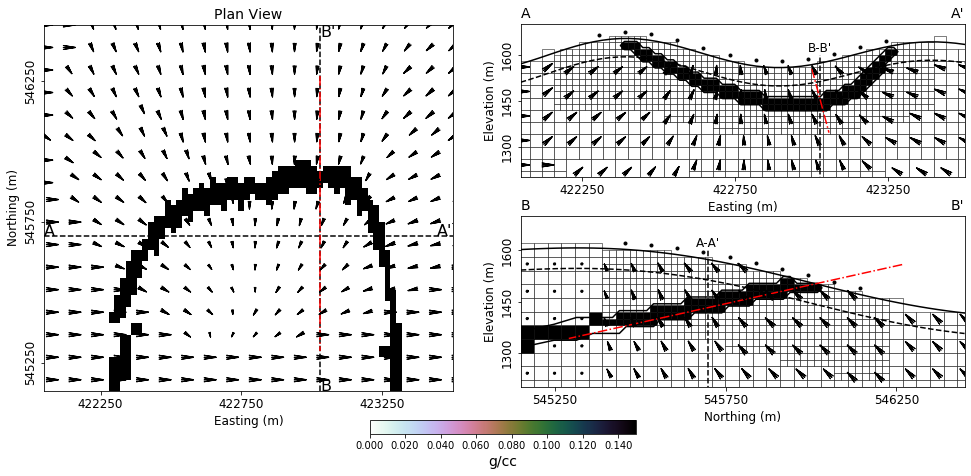

In [51]:
# fig, axs = plt.figure(figsize=(16,8)), plt.subplot()
fig = plt.figure(figsize=(14,8))

indz = 2
indy = int(mesh3D.nCy/2)-6
indx = int(mesh3D.nCx/2)+12

xlim = [422050, 423500]
ylim = [545150, 546450]
zlim = [1000, 1600]

x = [422250, 422750, 423250]
y = [545250, 545750, 546250]
z = [1300, 1450, 1600]

airc = np.ones(mesh.nC, dtype='bool')
airc[actv] = 0
mout[airc,:] = 0

axs = plt.subplot(1,2,1)
modelTop = modelTree[indTop][indModel]

plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCz[indz], 
                      axs=axs, scale=6., 
                      lims=[xlim, ylim], 
                      color='k', resolution=80, normal='Z', 
                      actvMap=actvMap, zorder=3)


mesh.plotSlice(modelTop, normal = 'Z',ind=int(np.searchsorted(mesh.vectorCCz, 1480)), pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)
#     axs, im, cbar = plotModelSections(mesh, mplot, actv = actv, normal='z',subFact=subFact, scale=scale, ind=indz, cmap='pink_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
# plotTopo(topo, axs=axs, fill=False)
# plotMarkers(pts, azm, dip, ms = 50, color='r')
# plt.scatter(survey.srcField.rxList[0].locs[:,0],survey.srcField.rxList[0].locs[:,1], 5, color='k')

plt.plot(xlim, [mesh3D.vectorCCy[int(indy)], mesh3D.vectorCCy[int(indy)]], c='k', linestyle='--')
plt.text(xlim[0],mesh3D.vectorCCy[int(indy)],'A', fontsize = 16)
plt.text(xlim[1],mesh3D.vectorCCy[int(indy)],"A'", fontsize = 16, ha = 'right')
plt.plot([mesh3D.vectorCCx[int(indx)], mesh3D.vectorCCx[int(indx)]], ylim, c='k', linestyle='--')
plt.text(mesh3D.vectorCCx[int(indx)], ylim[0],'B', fontsize = 16)
plt.text(mesh3D.vectorCCx[int(indx)], ylim[1],"B'", fontsize = 16, va = 'top')

# Plot fold axis
plt.plot(foldVec[:,0], foldVec[:,1], ylim, c='r', linestyle='-.')

axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
axs.set_xlabel('Easting (m)', size=12)
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
axs.set_ylabel('Northing (m)', size=12)
pos = axs.get_position()
axs.set_aspect('equal')
axs.set_position([pos.x0-0.05, pos.y0-0.01,  pos.width*1.15, pos.height*1.15])
axs.set_title('Plan View', fontsize=14)

axs = plt.subplot(2,2,2)
#     axs, im, cbar = plotModelSections(mesh, mplot, normal='y', actv = actv,subFact=subFact, scale=scale, ind=indy, cmap='pink_r', axs=axs,xlim=xlim, ylim=zlim, vmin=vmin, vmax=vmax)

plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCy[indy], 
                      axs=axs, scale=6., 
                      lims=[xlim, zlim], 
                      color='k', resolution=80, normal='Y', 
                      actvMap=actvMap, zorder=3)

im = mesh.plotSlice(modelTree, normal='Y', 
               ind=int(np.searchsorted(mesh.vectorCCy, mesh3D.vectorCCy[indy])), 
               grid=True, pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)
plotModelSections(mesh3D, model,normal='y', actv = actv3D, ind=indy, cmap='pink_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

# plotModelSections(mesh, theta, phi, normal='y', ind=indy,subFact=4, scale=7., cmap='pink_r', axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

topodrapped = topo.copy()
topodrapped[:,-1] -= np.sum(mesh.hz[-indz-1:])

plotProfile(topo, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')

plot(np.r_[mesh3D.vectorCCx[indx], mesh3D.vectorCCx[indx]], zlim, 'k--')
text(mesh3D.vectorCCx[indx], zlim[1],"B-B'", va='bottom', ha='center', size=12)
plotProfile(topodrapped, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k--')

plotProfile(survey.srcField.rxList[0].locs, [xlim[0],mesh3D.vectorCCy[int(indy)]], [xlim[1],mesh3D.vectorCCy[int(indy)]],
                         18, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k.')
# Plot fold axis
Rx = np.vstack(
    (np.r_[np.cos(np.deg2rad(15)), -np.sin(np.deg2rad(15))],
     np.r_[np.sin(np.deg2rad(15)), np.cos(np.deg2rad(15))])
)

line = np.dot(Rx, np.c_[foldVec[:,0]-x0,foldVec[:,2]-z0].T )


plt.plot(line[0,:]+x0, line[1,:]+z0, c='r', linestyle='-.')

#     cbar.remove()
axs.set_xlabel('Easting (m)', size=12)
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
axs.set_yticks(list(map(int, z)))
axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0,  pos.width*1.25, pos.height*1.25])
axs.set_title('A',loc='left', fontsize=14)
axs.set_title("A'",loc='right', fontsize=14)
axs.set_title("",loc='center', fontsize=14)


# NS PROFILE #
axs = plt.subplot(2,2,4)

#     axs, im, cbar = plotModelSections(mesh, mplot, normal='x', actv = actv, ind=indx, cmap='pink_r',subFact=subFact, scale=scale, axs=axs,xlim=ylim, ylim=zlim, vmin=vmin, vmax=vmax)
# im = mesh.plotSlice(mplot, 
#                ind=int(np.searchsorted(mesh.vectorCCx, mesh3D.vectorCCx[indx])),
#                normal='X', pcolorOpts={"cmap":'cubehelix_r'}, grid=True, ax=axs)

plotVectorsOctree(mesh, theta[actv], phi[actv], mesh3D.vectorCCx[indx], 
                      axs=axs, scale=6., 
                      lims=[ylim, zlim], 
                      color='k', resolution=80, normal='X', 
                      actvMap=actvMap, zorder=3)
im = mesh.plotSlice(modelTree, normal='X', 
               ind=int(np.searchsorted(mesh.vectorCCx, mesh3D.vectorCCx[indx])), 
               grid=True, pcolorOpts={"cmap":'cubehelix_r'}, ax=axs)

plotModelSections(mesh3D, model,normal='x',actv = actv3D, ind=indx, contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)
# plotModelSections(mesh, mkvc(rz1), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', axs=axs, vmin=0. ,vmax=0.1, fill=False)

# plotModelSections(mesh, mkvc(mout), normal='x', ind=indx,subFact=4, scale=7., cmap='pink_r', axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

plot(np.r_[mesh3D.vectorCCy[indy], mesh3D.vectorCCy[indy]], zlim, 'k--')
text(mesh3D.vectorCCy[indy], zlim[1],"A-A'", va='bottom', ha='center', size=12)
plotProfile(topo, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k')

plotProfile(topodrapped, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k--')

plotProfile(survey.srcField.rxList[0].locs, [mesh3D.vectorCCx[int(indx)],ylim[0]], [mesh3D.vectorCCx[int(indx)],ylim[1]],
                         18, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k.')
# Plot fold axis
plt.plot(foldVec[:,1], foldVec[:,2], ylim, c='r', linestyle='-.')

#     cbar.remove()
axs.set_xlabel('Northing (m)', size=12)
axs.set_xticks(list(map(int, y)))
axs.set_xticklabels(map(str, map(int, y)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
axs.set_yticks(list(map(int, z)))
axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0+0.06,  pos.width*1.25, pos.height*1.25])
axs.set_title('B',loc='left', fontsize=14)
axs.set_title("B'",loc='right', fontsize=14)
axs.set_title("",loc='center', fontsize=14)


axbar = plt.axes([pos.x0-0.15, pos.y0-0.025,  pos.width*.75, pos.height*.75])
cbar = plt.colorbar(im[0], orientation='horizontal',format='%.3f')
# cbar.set_ticks(np.linspace(-.0,0.1,4))
cbar.set_label("g/cc", size=14)
#     axbar.text(pos.x0+0.5, pos.y0-.45,'g/cc', size=14)
axbar.axis('off')

plt.savefig(work_dir + 'InterpolatedDip.png', bbox_inches='tight', dpi=300)

In [52]:
from SimPEG.Utils import speye, kron3
nC = int(actv.sum())

wr = prob.getJtJdiag(np.zeros(nC))
wr = (wr/np.max(wr)) 
wr = wr**0.5



prob.unpair()
survey.pair(prob)

#actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap,
                            gradientType='total')
reg1.norms = np.c_[0., 2, 2, 0]
# reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
reg1.alpha_z = 4
reg1.alpha_y = 1
reg1.alpha_s = 1
# reg1.eps_p = 1e-3
# reg1.eps_q = 1e-3
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
reg1.mref = np.zeros(nC)

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap,
                            gradientType='total')
reg2.norms = np.c_[0., 2, 2, 0]
# reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
reg2.alpha_z = 4
reg2.alpha_y = 1
reg2.alpha_s = 1
# reg2.eps_p = 1e-3
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
reg2.mref = np.zeros(nC)


reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=50, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=4e+4)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1e0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=50, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(int(actv.sum()))*1e-4  # Starting model
prob.model = m0
mrec_ROT = inv.run(m0)
m_l2_ROT = invProb.l2model

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)


Use Simple
Use Simple
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.00e+04  9.29e+06  2.39e-06  9.29e+06    2.46e+02      0              
Start CG solve
CG solve time: 27.074437618255615
   1  2.00e+04  1.70e+03  6.03e-02  2.90e+03    2.39e+02      0              
Start CG solve
CG solve time: 26.78844428062439
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.09808172758024572 eps_q: 0.09808172758024572
eps_p: 0.09808172758024572 eps_q: 0.09808172758024572
delta phim:    nan
   2  1.00e+04  4.08e+02  1.50e-01  1.91e+03    2.27e+02      0   Skip BFGS  
Start CG solve
CG solve time: 26.6361882686615
delta ph

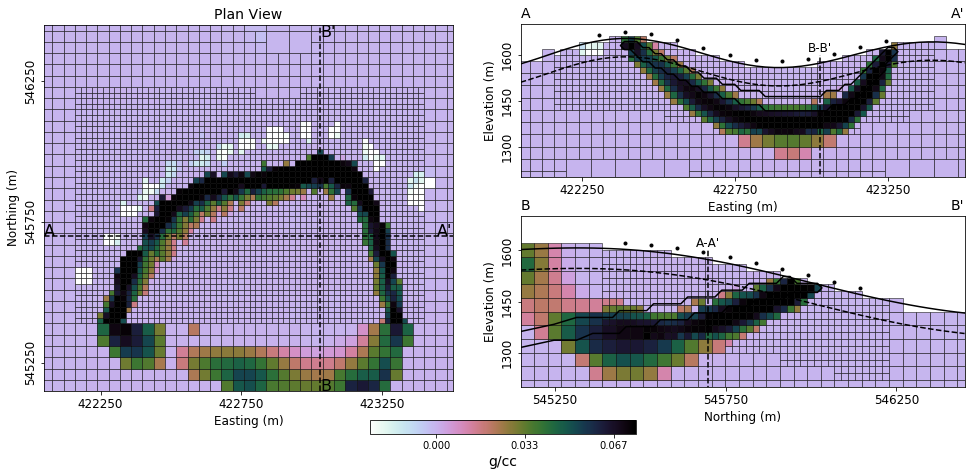

In [53]:
fileName = 'GRAV_Synthetic_ROTl0220_Learningv2.png'
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)
plot3Panels(actvMap*invProb.model,fileName, vmin=-0.025, vmax=.075, plotMarker=False)